# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

from helpers import *
from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
nltk.download('punkt')
import re
import statsmodels.api as sm

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sprok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%%capture
%run ./milestoneP2.ipynb

In [3]:
# Pre merge dataframe of Milestone 2, will build on this one:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
display(generate_missing_info(movies))

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
53167,24325293,/m/03yj_xk,The Plough and the Stars,1936,NaN,72.0,[English Language],[USA],"[Drama, Black-and-white]"
70219,10387338,/m/02qb5hk,She Married Her Boss,1935,NaN,85.0,[English Language],[USA],"[Romance Film, Comedy, Black-and-white, Comedy..."
24499,21736720,/m/05mwxq_,Love Simple,2009,NaN,86.0,[English Language],[USA],"[Romance Film, Indie, Comedy]"
67315,5708740,/m/0f0df1,The Adventures of Superboy,1961,NaN,26.0,[English Language],[USA],"[Short Film, Action]"
45042,12732947,/m/02x2k3h,Gambling Lady,1934,NaN,66.0,[English Language],[USA],"[Crime Fiction, Romance Film, Drama, Black-and..."


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [4]:
# Dataframe obtained at end of Milestone 2, obsolete now !

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
943,17441828,/m/04lqvly,Waltz with Bashir,2008,85.0,"[Arabic Language, English Language, German Lan...","[USA, Belgium, Switzerland, France, Israel, Ge...","[History, Experimental film, Animation, Drama,...",NaN,NaN,11125849.0,0.000561
3942,101523,/m/0prrm,Jay and Silent Bob Strike Back,2001,104.0,[English Language],[USA],"[Road movie, Stoner film, Buddy film, Comedy]",6.798695,150491.0,33788161.0,0.002386
435,9309429,/m/0283_zv,The Hustler,1961,135.0,[English Language],[USA],"[Sports, Drama, Black-and-white]",NaN,NaN,7600000.0,0.018219
4941,705984,/m/034bxn,Magnum Force,1973,123.0,[English Language],[USA],"[Thriller, Crime Fiction, Action Thrillers, My...",NaN,NaN,44680473.0,0.036753
6392,25161531,/m/09gb7tk,Oleanna,1994,90.0,[English Language],"[USA, United Kingdom]",[Drama],NaN,NaN,124693.0,0.000015


(6946, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       6946 non-null   int64  
 1   id_freebase   6946 non-null   object 
 2   name          6946 non-null   object 
 3   year          6946 non-null   int32  
 4   runtime       6937 non-null   float64
 5   lang          6946 non-null   object 
 6   countries     6946 non-null   object 
 7   genres        6946 non-null   object 
 8   review        2714 non-null   float64
 9   nbr_review    2714 non-null   float64
 10  revenue       6946 non-null   object 
 11  revenue_part  6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 624.2+ KB


None

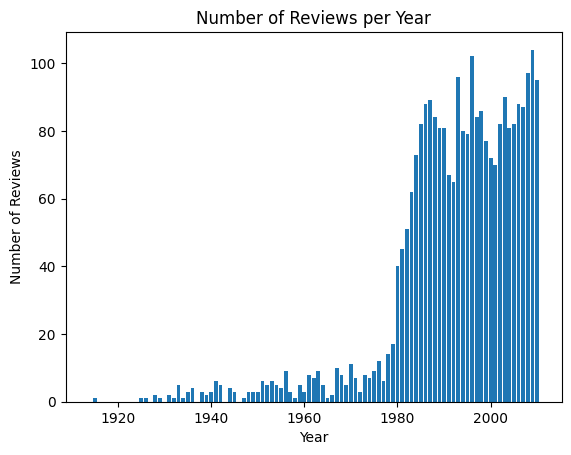

In [5]:
reviews_count_per_year = movies2_clean.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year['year'], reviews_count_per_year['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

# Structure

## 0) Overview of the data used 

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

In [6]:
# # Data Path
# DATA_PATH = '../data/'
# MOVIES_FOLDER = DATA_PATH+'MovieSummaries/'
# MOVIES_DATASET = MOVIES_FOLDER+"movie.metadata.tsv"

# # Load Data
# df_raw = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
#                                                   'box_office','runtime','lang','countries','genres'])

In [7]:
# # MILESTONE P2
# movies = df_raw.copy()
# movies = data_missing(movies)
# movies = fuse_duplicates(movies, col_check=['name'], year='date', runtime='runtime',
#                          col_len=['lang', 'countries', 'genres'], col_null=['box_office', 'runtime'])
# movies = data_format(movies)
# movies.rename(columns={'box_office': 'revenue'}, inplace=True)  # maybe add this inside data_format ?
# movies.rename(columns={'date': 'year'}, inplace=True)           # maybe add this inside data_format ?
# movies = data_clean(movies)
# movies_all= movies.copy() # copy of all movies before filtering
# movies = data_filter(movies)

# MEHDI: USE movies DF WITHOUT MODIFYING IT FOR THIS SECTION !!!!

### a) Selection of niches genre

In [8]:
subsets = select_subsets(movies)
print('Number of subsets: {}'.format(len(subsets)))

Number of subsets: 244


### b) Trend graphs for some genres


Subset: Horror
	2571 | 28821 (size subset | movies)
	= 0.0892 %


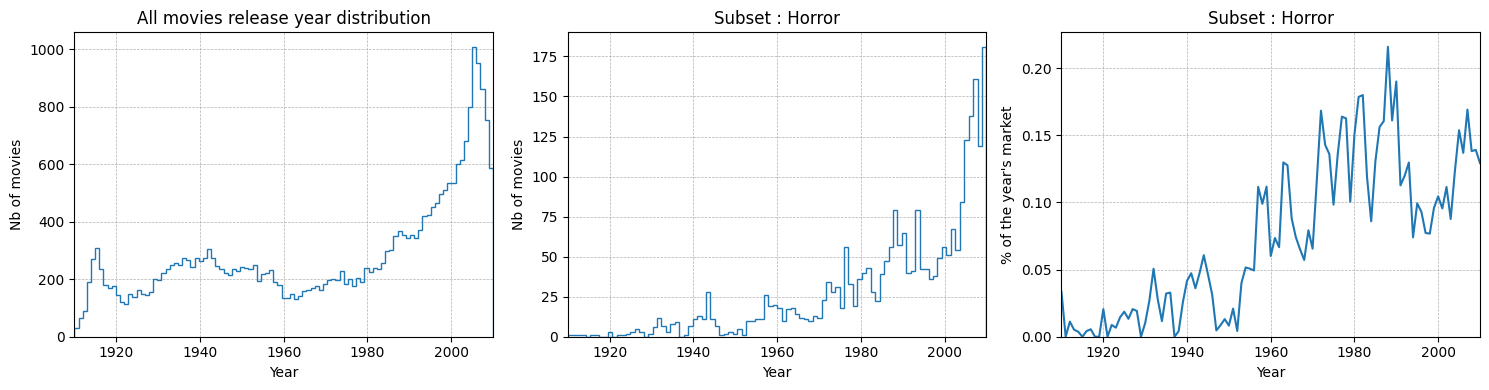

In [9]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Horror')
viz_subset(i, subsets, movies)

### c) Trend automatic detection

In [10]:
QUALITY = 0.2

Peaks of subset Animation: [1937, 1955, 2006]
Quality of peaks: [0.8944550792731157, 0.10797647002214027, 0.2703500979062703]


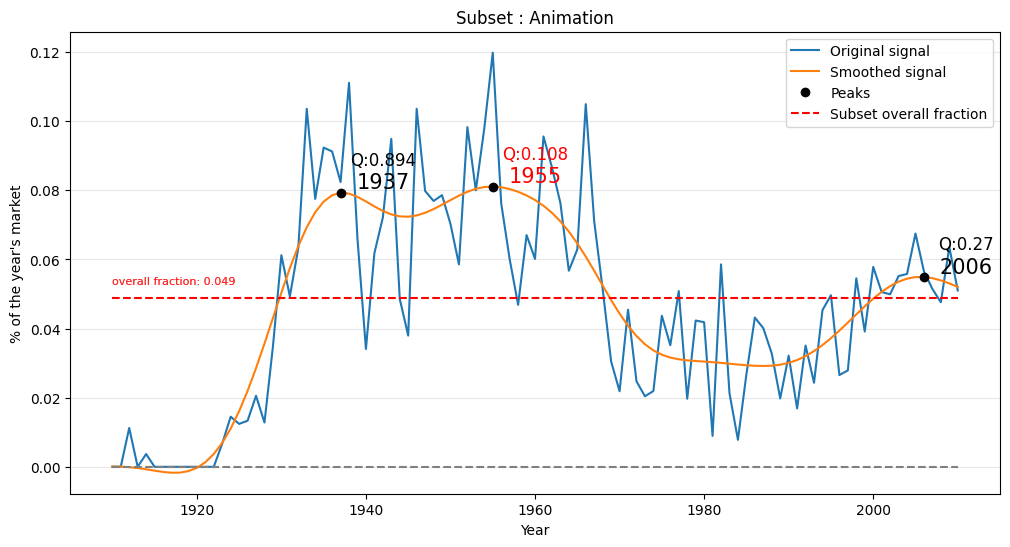

In [11]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Animated Musical')
i = 17
print('Peaks of subset {}: {}'.format(subsets[i][0], get_peaks(movies, subsets, i)[0]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[1]))
fig = viz_peaks(movies, subsets, i)

In [12]:
trends = get_trends(movies, subsets, QUALITY)

print('Trend detection for 5 first subsets:')
display(trends[:10])

Trend detection for 5 first subsets:


[('Absurdism', [1977, 1995]),
 ('Action', [1974]),
 ('Action Comedy', []),
 ('Action Thrillers', [1975, 1995]),
 ('Action/Adventure', [1973]),
 ('Addiction Drama', [1955, 1995]),
 ('Adult', [1973]),
 ('Adventure', [1939]),
 ('Adventure Comedy', [1947, 1985]),
 ('Airplanes and airports', [1931, 1960, 1980])]

### d) Construction of potential pivotal movie sets 
 

In [13]:
candidates = get_candidates(subsets, trends)
print('Number of candidates: {}'.format(len(candidates)))
print('\nCandidates for first trend:')
show_candidates(candidates, 386)

Number of candidates: 387

Candidates for first trend:
Candidates of pivotal of genre Zombie Film, for trend in 2009


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
93,24039457,/m/0crx1wl,ZA: Zombies Anonymous,2005,NaN,118.0,[English Language],[USA],"[Parody, B-movie, Horror, Zombie Film]"
319,1033297,/m/0401sg,Resident Evil,2002,102441078.0,100.0,[English Language],"[USA, France, Canada, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Adventure,..."
1498,7585416,/m/0kvbvd,Route 666,2001,NaN,90.0,[English Language],"[USA, Canada]","[Zombie Film, Horror, Creature Film]"
5446,3238135,/m/090glv,House of the Dead,2003,13818181.0,90.0,[English Language],"[USA, Canada, Germany]","[Thriller, Horror, World cinema, Action/Advent..."
6565,5386187,/m/0djhtl,Vampires Vs. Zombies,2004,NaN,83.0,[English Language],[USA],"[Zombie Film, B-movie, Horror, Slasher, Indie]"
...,...,...,...,...,...,...,...,...,...
71005,915499,/m/03pkmt,Land of the Dead,2005,46770602.0,93.0,"[French Language, Polish Language, Italian Lan...","[USA, France, Canada]","[Thriller, Science Fiction, Horror, Indie, Doo..."
71072,4742175,/m/0ckyr9,Mortuary,2006,NaN,93.0,[English Language],[USA],"[Cult, Zombie Film, Horror]"
72297,13656791,/m/03cd6pg,The Stink of Flesh,2005,NaN,82.0,[English Language],[USA],"[Cult, Black comedy, Horror, Comedy, Zombie Film]"
73241,9396573,/m/02875q0,Zombie Town,2007,NaN,95.0,[English Language],[USA],"[Zombie Film, Horror, B-movie, Creature Film]"


### *) List of candidates for training

In [14]:
c = show_candidates(candidates, find_candidates(candidates,'Adventure',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>1000000]

Candidates of pivotal of genre Adventure, for trend in 1939


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
46842,2259030,/m/06zxb7,Tarzan the Ape Man,1932,2540000.0,189.0,[English Language],[USA],"[Action, Pre-Code, Adventure, Black-and-white]"
26841,16782,/m/048rn,King Kong,1933,1856000.0,100.0,[English Language],[USA],"[Monster movie, Horror, Adventure, Stop motion..."
38805,5482994,/m/0dnv98,Treasure Island,1934,1164000.0,103.0,[English Language],[USA],"[Swashbuckler films, Adventure, Black-and-whit..."
55990,61498,/m/0gnhr,"The Personal History, Adventures, Experience, ...",1935,1621000.0,130.0,[English Language],[USA],"[Adventure, Costume drama, Black-and-white, Dr..."
67731,3139727,/m/08tz29,The Crusades,1935,1700000.0,126.0,[English Language],[USA],"[Adventure, Costume drama, Historical fiction,..."
65206,62084,/m/0gssy,The Adventures of Robin Hood,1938,3981000.0,102.0,[English Language],[USA],"[Swashbuckler films, Adventure, Costume drama,..."


In [15]:
c = show_candidates(candidates, find_candidates(candidates,'Anime',year=2004)).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100]

Candidates of pivotal of genre Anime, for trend in 2004


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
8422,3228403,/m/01kzd_v,Ghost in the Shell,1995,2287714.0,85.0,"[Japanese Language, English Language, Spanish ...","[USA, Japan]","[Thriller, Science Fiction, Japanese Movies, A..."
70052,4198757,/m/0bpj6p,Space Truckers,1996,1614266.0,94.0,[English Language],"[USA, Ireland, United Kingdom]","[Science Fiction, Road movie, Comedy-drama, Sa..."
57261,2460704,/m/07fpw5,Pokémon: The First Movie,1998,163644662.0,95.0,"[Japanese Language, English Language]","[USA, Japan]","[Science Fiction, Fantasy Adventure, Japanese ..."
7823,5579355,/m/0dtjpk,Digimon: The Movie,2000,16643191.0,88.0,[English Language],"[USA, Japan]","[Thriller, Fantasy Adventure, Japanese Movies,..."
47494,4648834,/m/0cfdsq,Pokémon: Spell Of The Unown,2001,68411275.0,91.0,"[Japanese Language, English Language]","[USA, Japan]","[Japanese Movies, World cinema, Animation, Act..."
59000,11242,/m/02_qt,Final Fantasy: The Spirits Within,2001,85131830.0,106.0,[English Language],"[USA, Japan]","[Science Fiction, Japanese Movies, Adventure, ..."
50561,1989045,/m/06c805,Pokémon 4Ever,2002,28023563.0,81.0,"[Japanese Language, English Language]","[USA, Japan]","[Fantasy Adventure, Japanese Movies, Adventure..."
27047,1489050,/m/055crg,Pokémon Heroes,2003,20867919.0,68.0,"[Japanese Language, English Language]","[USA, Japan]","[Fantasy Adventure, Japanese Movies, World cin..."


In [16]:
c = show_candidates(candidates, find_candidates(candidates,'Erotic thriller',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100000000]

Candidates of pivotal of genre Erotic thriller, for trend in 1994


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
1243,129295,/m/0yx7h,Fatal Attraction,1987,320145693.0,119.0,[English Language],[USA],"[Thriller, Horror, Mystery, Psychological thri..."
5317,2541839,/m/07lz72,Sea of Love,1989,110879513.0,113.0,[English Language],[USA],"[Thriller, Crime Fiction, Detective, Mystery, ..."
13690,481649,/m/02fqxm,Basic Instinct,1992,352927224.0,127.0,[English Language],"[USA, France]","[LGBT, Thriller, Mystery, Psychological thrill..."
49572,11059900,/m/02qzmz6,Sliver,1993,116300000.0,107.0,[English Language],[USA],"[Thriller, Erotic thriller, Romance Film, Psyc..."


In [17]:
c = show_candidates(candidates, find_candidates(candidates,'Family Film',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>1000000]

Candidates of pivotal of genre Family Film, for trend in 1937


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
20859,2175661,/m/06sjhv,Little Women,1933,2000000.0,115.0,"[English Language, German Language]",[USA],"[Costume drama, Family Drama, Black-and-white,..."
38805,5482994,/m/0dnv98,Treasure Island,1934,1164000.0,103.0,[English Language],[USA],"[Swashbuckler films, Adventure, Black-and-whit..."
52056,74962,/m/0jz2p,Modern Times,1936,8663577.0,85.0,[English Language],[USA],"[Silent film, Satire, Drama, Comedy, Family Film]"


In [18]:
c = show_candidates(candidates, find_candidates(candidates,'Film noir',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Film noir, for trend in 1949


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
40680,74984,/m/0jz89,Suspicion,1941,4500000.0,99.0,[English Language],[USA],"[Thriller, Mystery, Romance Film, Film noir]"
3898,1056686,/m/0426cx,Cat People,1942,4000000.0,73.0,"[Czech Language, English Language, Serbian lan...",[USA],"[Thriller, Romance Film, Horror, Black-and-whi..."
21245,73438,/m/0jqly,Double Indemnity,1944,5000000.0,108.0,[English Language],[USA],"[Thriller, Crime Fiction, Drama, Film noir]"
45395,2279601,/m/070fnm,Gaslight,1944,4613000.0,114.0,[English Language],[USA],"[Thriller, Costume drama, Psychological thrill..."
73261,80488,/m/0ktpx,Spellbound,1945,7000000.0,110.0,[English Language],[USA],"[Thriller, Therimin music, Psychological thril..."
43303,1397142,/m/04zb7s,Key Largo,1948,8125000.0,101.0,[English Language],[USA],"[Crime Fiction, Thriller, Gangster Film, Black..."


In [19]:
c = show_candidates(candidates, find_candidates(candidates,'Gangster Film',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Gangster Film, for trend in 1974


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
22195,1449256,/m/052g_x,Point Blank,1967,3500000.0,92.0,[English Language],[USA],"[Thriller, Crime Fiction, Gangster Film, Myste..."
23174,68245,/m/0hvvf,Bonnie and Clyde,1967,50700000.0,112.0,[English Language],[USA],"[Crime Fiction, Heist, Gangster Film, Crime Dr..."
12776,1235054,/m/04kvfm,Across 110th Street,1972,10000000.0,102.0,[English Language],[USA],"[Thriller, Crime Fiction, Gangster Film, Actio..."
33310,2466773,/m/07g1sm,The Godfather,1972,268500000.0,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa..."
55357,62440,/m/0gw7p,The Sting,1973,159616327.0,129.0,[English Language],[USA],"[Crime Fiction, Buddy film, Gangster Film, Per..."


In [20]:
c = show_candidates(candidates, find_candidates(candidates,'Heist',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Heist, for trend in 1972


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
23174,68245,/m/0hvvf,Bonnie and Clyde,1967,50700000.0,112.0,[English Language],[USA],"[Crime Fiction, Heist, Gangster Film, Crime Dr..."
50762,5719024,/m/0f0_04,The War Wagon,1967,6000000.0,101.0,[English Language],[USA],"[Action/Adventure, Heist, Western, Caper story]"
67369,2367145,/m/076y2d,The Thomas Crown Affair,1968,14000000.0,102.0,[English Language],[USA],"[Crime Fiction, Heist, Thriller, Crime Thriller]"
20651,933321,/m/03r8x1,Kelly's Heroes,1970,5200000.0,149.0,"[French Language, German Language, English Lan...","[USA, Yugoslavia, Socialist Federal Republic o...","[Crime Fiction, Heist, Adventure, Anti-war, Ac..."


In [21]:
c = show_candidates(candidates, find_candidates(candidates,'Monster movie',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>10000]

Candidates of pivotal of genre Monster movie, for trend in 1960


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
27435,76387,/m/0k4lt,The Thing,1951,1950000.0,87.0,[English Language],[USA],"[Monster movie, Therimin music, Science Fictio..."
26322,72317,/m/0jhpk,Creature from the Black Lagoon,1954,1300000.0,80.0,[English Language],[USA],"[Monster movie, Science Fiction, Horror, Adven..."


In [22]:
c = show_candidates(candidates, find_candidates(candidates,'Teen',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100000000]

Candidates of pivotal of genre Teen, for trend in 1986


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
186,336846,/m/01xlqd,Grease,1978,394589888.0,225.0,[English Language],[USA],"[Romantic comedy, LGBT, Musical, Comedy, Roman..."
60939,284957,/m/01pwpj,Porky's,1982,111289673.0,94.0,[English Language],"[USA, Canada]","[Sex comedy, Coming of age, Comedy, Teen]"


In [23]:
c = show_candidates(candidates, find_candidates(candidates,'Zombie Film',year=2009)).sort_values('year').dropna(subset=['revenue'])
c[c.revenue>100000000]

Candidates of pivotal of genre Zombie Film, for trend in 2009


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
319,1033297,/m/0401sg,Resident Evil,2002,102441078.0,100.0,[English Language],"[USA, France, Canada, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Adventure,..."
11998,538455,/m/02my7z,Dawn of the Dead,2004,102356381.0,101.0,[English Language],"[USA, France, Japan, Canada]","[Thriller, Science Fiction, Horror, Doomsday f..."
62240,2271177,/m/06_sc3,Resident Evil: Extinction,2007,147717833.0,88.0,[English Language],"[USA, France, Australia, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Sci-Fi Hor..."
10634,6641931,/m/0gfsq9,I Am Legend,2007,585349010.0,100.0,[English Language],[USA],"[Thriller, Albino bias, Science Fiction, Horro..."


### *) Save all subsets visualizations as images

In [24]:
#get_all_viz(movies, subsets)

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


## Further cleaning and data gathering

In [25]:
# Start with the pre-merge df of Milestone 2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
generate_missing_info(movies)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
49901,3053338,/m/08ncxj,BigLove,2001,NaN,10.0,[English Language],[USA],"[Short Film, Drama, Comedy]"
12239,20484661,/m/04z_18x,Arthur and Lillie,1975,NaN,29.0,[English Language],[USA],"[Short Film, History, Biography, Documentary]"
53060,1166096,/m/04cv9m,All the King's Men,2006,9450897.0,128.0,[English Language],"[USA, Germany]","[Thriller, Remake, Period piece, Drama, Film a..."
23731,1693395,/m/05nxmf,Varsity Blues,1999,54294169.0,104.0,[English Language],[USA],"[Sports, Drama, Coming of age, Comedy, Teen]"
665,24009114,/m/07k4ypc,Strange Illusion,1945,NaN,85.0,[English Language],[USA],"[Crime Fiction, Thriller, Black-and-white, Mys..."


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


### Cleaning big IMDB dataset

In [26]:
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
display(imdb_vanilla.isnull().sum())
display(imdb_vanilla[imdb_vanilla['gross_income']!='0'].sample(5))

,id,name,year,rating,duration,votes,gross_income
1975240,tt3904184,Daitarn 3,(1978–1979),11.0,0 min,0,0
2366962,tt1292976,Pasapalabra,(2000– ),11.0,0 min,0,0
1994645,tt9849840,Mega Man: Fully Charged,(2018– ),11.0,0 min,0,0
1056202,tt3026112,What Are Friends For?,(2013),11.0,7 min,0,0
561252,tt6055560,Cheat Day Chowdown,(2016– ),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

,id,name,year,rating,duration,votes,gross_income
1466833,tt2226597,The Mountain Between Us,(2017),6.4,112 min,74587,"30,348,555"
6894,tt0059079,Come Drink with Me,(1966),6.9,95 min,"4,252","17,754"
2061803,tt0037522,Back to Bataan,(1945),6.6,95 min,"4,040","1,316,495"
12363,tt1042916,Totally Spies! The Movie,(2009),6.3,75 min,661,"54,606"
9377,tt0042333,The Clouded Yellow,(1950),6.9,95 min,869,"2,541,320"


In [27]:
imdb = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

# Cleaning the year column: removing some characters and extracting starting year only
imdb = imdb[~imdb['year'].astype(str).str.contains('-|–')]
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
imdb['year'] = imdb['year'].replace('', np.nan)
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[:, 'year'] = imdb['year'].astype('Int64', errors='ignore')

# Dataframe is huge, and we do not care about movies post-2017: let's reduce it a bit
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)

# From gross income, remove undesired characters and turn to float:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
imdb['gross_income'] = pd.to_numeric(imdb['gross_income'], errors='coerce')
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)

# From votes, remove undesired characters and turn to float:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb = imdb[imdb['rating'] <= 10]

# Extract number from duration:
imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')  

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
display(imdb[~(imdb['gross_income'].isna())!=0].sample(5))

,id,name,year,rating,duration,votes,gross_income
541895,tt0340871,No Man's Land,2000,6.6,25.0,16.0,NaN
455244,tt4059636,Dames 4,2015,6.3,90.0,369.0,NaN
548037,tt0353777,Nagarathil Samsara Vishayam,1991,5.2,NaN,38.0,NaN
147431,tt1314435,Our Friends in the North,1996,8.0,70.0,44.0,NaN
112709,tt5477242,Sifu vs the Undead,2015,5.3,2.0,8.0,NaN


(251689, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 251689 entries, 0 to 635804
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            251689 non-null  object 
 1   name          251689 non-null  object 
 2   year          251689 non-null  Int64  
 3   rating        251689 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         251689 non-null  object 
 6   gross_income  29023 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 15.6+ MB


None

,id,name,year,rating,duration,votes,gross_income
412441,tt0425061,Get Smart,2008,6.5,110.0,216333.0,130319208.0
119900,tt0101529,Cabeza de Vaca,1991,6.9,112.0,1141.0,789127.0
2474,tt0106309,Joshua Tree,1993,5.6,106.0,5790.0,31888805.0
301008,tt1179947,American: The Bill Hicks Story,2009,7.7,102.0,4900.0,90275.0
382255,tt0054426,The Long Absence,1961,7.0,94.0,775.0,43539.0


In [28]:
# Year and duration are elements used to detect and fuse duplicates: need them clean
imdb = imdb.dropna(subset=['year', 'duration'])

# If both votes and gross_income are unknown, then the row is of no use
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
40309,tt5062640,A Knock at the Door,2016,8.2,8.0,16.0,NaN
51557,tt1118974,Polnolunie,2005,2.4,193.0,32.0,NaN
115268,tt1255894,Porn Editor,2008,7.1,8.0,22.0,NaN
159693,tt0705996,Space Academy,1977,6.9,22.0,12.0,NaN
211069,tt0367493,An American Family Revisited: The Louds 10 Yea...,1983,7.9,59.0,20.0,NaN


(214143, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214143 entries, 0 to 214142
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            214143 non-null  object 
 1   name          214143 non-null  object 
 2   year          214143 non-null  Int64  
 3   rating        214143 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         214143 non-null  object 
 6   gross_income  27935 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.6+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.00
duration,0.00
votes,0.00
gross_income,86.95


In [29]:
# Are there any doublons ?

display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))
display(imdb[(imdb['name']=='Unconditional') & (imdb['year']==2012)]) 
display(imdb[(imdb['name']=='Blood Money') & (imdb['year']==2012)]) 
display(imdb[(imdb['name']=='Star Wars') & (imdb['year']==1977)]) 

Rows with real duplicates: 
                              name  year  duration
3134                 Unconditional  2012      92.0
4210                   Blood Money  2012     109.0
12047   The Game Ain't 4 Everybody  2009     105.0
13546                      Misfits  2015      20.0
14199          Trouble in Paradise  1989     100.0
...                            ...   ...       ...
214138                   Game Face  2017      42.0
214139                   Game Face  2017      42.0
214140                   Game Face  2017      42.0
214141                   Game Face  2017      42.0
214142                   Game Face  2017      42.0

[10243 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,7.0,92.0,4800.0,1005800.0
199175,tt1967651,Unconditional,2012,6.5,92.0,741.0,NaN


,id,name,year,rating,duration,votes,gross_income
4210,tt2246595,Blood Money,2012,5.0,109.0,1480.0,NaN
189060,tt1753521,Blood Money,2012,3.2,109.0,592.0,74491.0


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


In [30]:
# Need to fuse the duplicates, but the dataframe is huge so let's use Spark to go faster
imdb_clean = imdb.copy(deep=True)

imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

,id,name,year,rating,duration,votes,gross_income
25818,tt0267559,Hostinec U létavého draka,1971,6.4,84.0,15.0,NaN
41726,tt4193956,Mohini 9886788888,2006,4.3,158.0,22.0,NaN
182426,tt1981645,Josef,2011,6.0,90.0,438.0,46796.0
197596,tt1547959,Pump Action,2007,6.5,5.0,9.0,NaN
183664,tt0047805,Air Strike,1955,4.7,67.0,55.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  Int64  
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 12.8+ MB


None

In [31]:
# Merge successful ?
display(imdb_clean[(imdb_clean['name']=='Unconditional') & (imdb_clean['year']==2012)]) 
display(imdb_clean[(imdb_clean['name']=='Blood Money') & (imdb_clean['year']==2012)])
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))
# Yes !

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,6.9,92.0,5541.0,1005800.0


,id,name,year,rating,duration,votes,gross_income
4210,tt2246595,Blood Money,2012,4.5,109.0,2072.0,74491.0


No duplicates
--------------------------------------------------------------------------------


None

### Original name map

In [32]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})

display(name_map_vanilla.sample(5))
display(name_map_vanilla.shape)
display(name_map_vanilla.info())

,tconst,primaryTitle,name,year,duration
7167964,tt29717917,Episode #11.168,Episode #11.168,2023,\N
7988575,tt4591814,Kiss Me,Kiss Me,2013,10
8268706,tt5228620,Viña 1992: Noche 2,Viña 1992: Noche 2,1992,\N
2696607,tt13154976,Most Desperate Acts of Survival,Most Desperate Acts of Survival,2020,\N
4236549,tt1599841,Let the Battle Begin!,Let the Battle Begin!,2010,\N


(9387091, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9387091 entries, 0 to 9387090
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   tconst        object
 1   primaryTitle  object
 2   name          object
 3   year          object
 4   duration      object
dtypes: object(5)
memory usage: 358.1+ MB


None

In [33]:
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)

display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [34]:
# Extract duration in minutes
name_map_vanilla['duration'] = name_map_vanilla['duration'].str.extract('(\d+\.\d+|\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['duration'] = name_map_vanilla['duration'].replace('', np.nan)

# Extract year
name_map_vanilla['year'] = name_map_vanilla['year'].str.extract('(\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['year'] = name_map_vanilla['year'].replace('', np.nan)
name_map_vanilla.loc[:, 'year'] = name_map_vanilla['year'].astype('Int64', errors='ignore')

# Get rid of missing data in duration and year
name_map = name_map_vanilla.copy(deep=True)
name_map = name_map_vanilla.dropna(subset=['duration', 'year']).reset_index(drop=True)

display(name_map.sample(5))
display(name_map.shape)
display(name_map.info())
generate_missing_info(name_map)


,tconst,primaryTitle,name,year,duration
912053,tt13018336,Außer Kontrolle,Außer Kontrolle,2021,45.0
2576096,tt7272810,Episode #1.4,Episode #1.4,2016,45.0
764560,tt1170393,Tambourine,Dayereh-e zangi,2008,110.0
118842,tt0144656,Törésvonalak II,Törésvonalak II,1997,70.0
884459,tt12792504,L'indifférence,L'indifférence,2005,3.0


(2644199, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644199 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 103.4+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


In [35]:
# Are there any doublons ?
check_doublons(name_map, col_check=['name'], year='year', runtime='duration')

# If that's the case let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.sample(5))
display(name_map_clean.shape)
display(name_map_clean.info())
generate_missing_info(name_map_clean)

Rows with real duplicates: 
                           name  year  duration
103      The Kiss in the Tunnel  1899       1.0
1262      Bread Upon the Waters  1913      11.0
1334          The Doctor's Duty  1913      11.0
1385                 Flood Tide  1913      11.0
1480                  The Idler  1914      11.0
...                         ...   ...       ...
2644083           Episode #1.10  2017      55.0
2644084            Episode #1.3  2017      55.0
2644129                  Broken  2017       4.0
2644167               Avsnitt 3  2017      44.0
2644168               Avsnitt 4  2017      45.0

[178245 rows x 3 columns]
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

,tconst,primaryTitle,name,year,duration
2554164,tt7122400,Kiki Mobile,Kiki Mobile,2017,60.0
1417294,tt1912894,Cookies and Misdemeanors,Cookies and Misdemeanors,2007,21.0
379005,tt0584035,Three Cheers for Little Boy Blue,Three Cheers for Little Boy Blue,1965,50.0
296309,tt0433904,Brutal Kombat,Brutal Kombat,1999,90.0
1669839,tt2402166,One Night in Seattle,One Night in Seattle,2013,90.0


(2526746, 5)

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


### IMDB MERGE

In [36]:
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})

display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
generate_missing_info(imdb_final)

,alt_name,name,year,runtime,rating,votes,revenue
88288,NaN,Deep Purple: King of Dreams,1990,5.0,7.3,15.0,NaN
67659,Dirty Dancing,Dirty Dancing,2017,130.0,3.1,6197.0,NaN
185038,NaN,Best of the Best,1996,107.0,5.1,54.0,NaN
77602,Weekend Warriors,Weekend Warriors,1986,89.0,4.4,331.0,351623.0
16097,Women in Arms,Donne armate,1991,149.0,6.7,22.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  158007 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
alt_name,23.20
name,0.00
year,0.00
runtime,0.00
rating,0.00
votes,0.00
revenue,86.42


In [37]:
# The "Star Wars" problem is taken care of

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars: Episode IV - A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


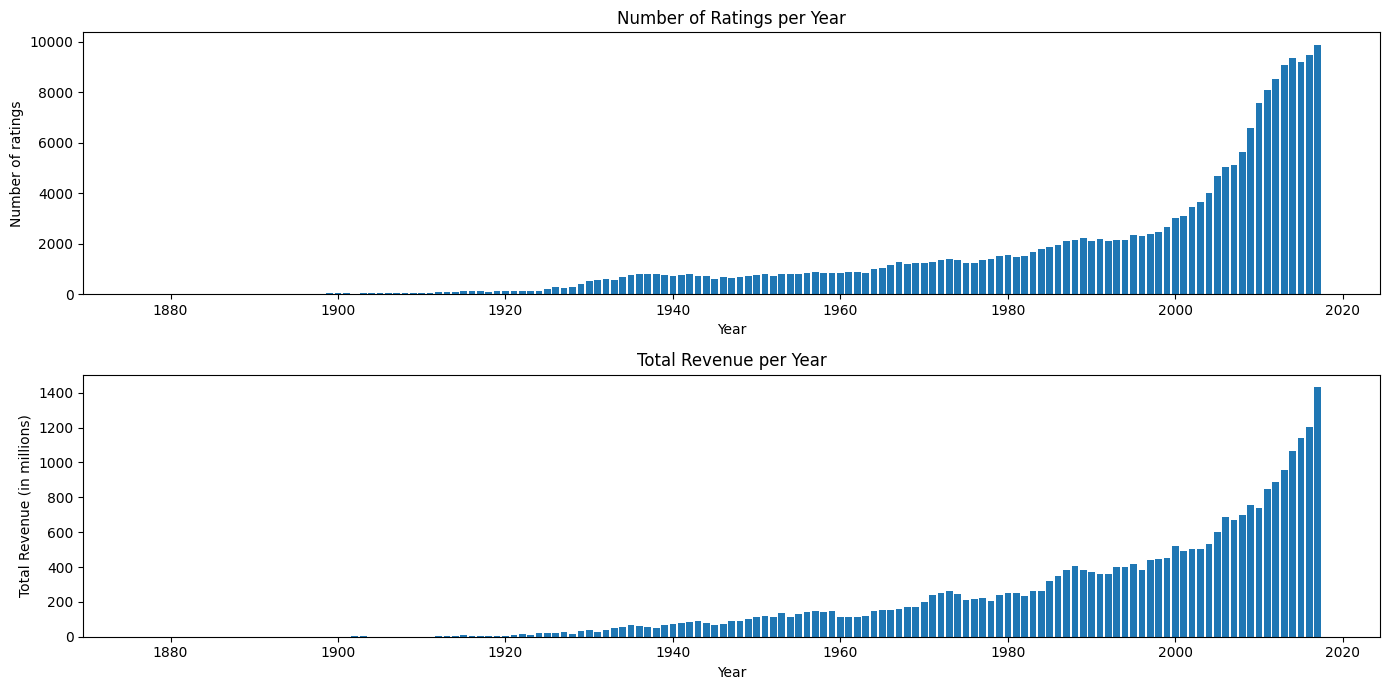

In [38]:
revenue_per_year_imdb = imdb_final.groupby('year')['revenue'].count().reset_index()
reviews_count_per_year_imdb = imdb_final.groupby('year')['rating'].count().reset_index()

fig = plt.figure(figsize=(14, 7))

# Plot for number of ratings per year
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.bar(reviews_count_per_year_imdb['year'], reviews_count_per_year_imdb['rating'])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Number of Ratings per Year')

# Plot for revenue per year
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.bar(revenue_per_year_imdb['year'], revenue_per_year_imdb['revenue'])
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue per Year')

plt.tight_layout()
plt.show()

In [39]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final['alt_name'] = imdb_final['alt_name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['alt_name'] = imdb_final['alt_name'].str.replace('\s+', ' ', regex=True).str.strip()
imdb_final['name'] = imdb_final['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['name'] = imdb_final['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


### IMDB_FINAL & MOVIELENS MERGE

In [40]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces

movies_lens['name'] = movies_lens['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_lens['name'] = movies_lens['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,rating,votes,year
4351,400654.0,99.0,Today's Special,6.2,34.0,2009
5231,5659286.0,90.0,Anomalisa,6.9,472.0,2015
5503,230069.0,84.0,Jimmy Vestvood Amerikan Hero,5.4,14.0,2016
4357,160112671.0,88.0,Underworld Awakening,6.1,1885.0,2012
670,79082515.0,102.0,Home Alone 3,5.1,632.0,1997


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  5619 non-null   float64
 1   runtime  5619 non-null   float64
 2   name     5619 non-null   object 
 3   rating   5619 non-null   float64
 4   votes    5619 non-null   float64
 5   year     5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

In [41]:
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,revenue_x,runtime,name,rating_x,votes_x,year,alt_name,rating_y,votes_y,revenue_y
182038,NaN,90.0,Lethal Panther,NaN,NaN,1990,nan,5.3,271.0,1300000.0
162207,NaN,34.0,GoGo Sentai Boukenger the Movie The Greatest P...,NaN,NaN,2006,nan,6.8,25.0,NaN
131913,NaN,56.0,Valley of the Lawless,NaN,NaN,1936,Valley of the Lawless,5.9,34.0,NaN
71382,NaN,92.0,Amor a la española,NaN,NaN,1967,Amor a la española,4.0,58.0,NaN
120141,NaN,3.0,Grand Theft Skyrim,NaN,NaN,2014,Grand Theft Skyrim,8.6,5.0,NaN


(205729, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   revenue_x  3111 non-null    float64
 1   runtime    205729 non-null  float64
 2   name       205729 non-null  object 
 3   rating_x   3111 non-null    float64
 4   votes_x    3111 non-null    float64
 5   year       205729 non-null  Int64  
 6   alt_name   205729 non-null  object 
 7   rating_y   205729 non-null  float64
 8   votes_y    205729 non-null  float64
 9   revenue_y  27934 non-null   float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 15.9+ MB


None

,Missing Data (%)
Column,
revenue_x,98.49
runtime,0.00
name,0.00
rating_x,98.49
votes_x,98.49
year,0.00
alt_name,0.00
rating_y,0.00
votes_y,0.00


In [42]:
# Fuse the revenue columns
annex['revenue'] = annex.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
annex = annex.drop(['revenue_x', 'revenue_y'], axis=1)

# Fuse the rating and votes columns
annex = fuse_scores_v2(annex, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y', score_col='rating', votes_col='votes')

# Adressing alt_name nan issue
annex['alt_name'] = annex['alt_name'].replace('nan', None)
annex['alt_name'].fillna(annex['name'], inplace=True)

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,runtime,name,year,alt_name,revenue,rating,votes
84704,4.0,Wet Wet Wet Temptation,1988,Wet Wet Wet Temptation,<NA>,5.8,5.0
104701,90.0,Norm of the North,2016,Norm of the North,17017118.0,3.4,9392.0
121750,10.0,How Husbands Taught Wives,1976,How Husbands Taught Wives,<NA>,6.0,11.0
8510,117.0,Aagey Se Right,2009,Aagey Se Right,49472.0,5.2,410.0
158835,11.0,The Workout,2008,The Workout,<NA>,7.4,19.0


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205729 non-null  float64
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   alt_name  205729 non-null  object 
 4   revenue   27972 non-null   object 
 5   rating    205729 non-null  float64
 6   votes     205729 non-null  float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
runtime,0.0
name,0.0
year,0.0
alt_name,0.0
revenue,86.4
rating,0.0
votes,0.0


In [43]:
display(annex[annex['name'].str.contains('The Godfather')])
display(annex[annex['name'].str.contains('Star Wars') & (annex.year<2000) ])

,runtime,name,year,alt_name,revenue,rating,votes
14,175.0,The Godfather,1972,The Godfather,190016411.0,9.2,1804773.0
15,202.0,The Godfather Part II,1974,The Godfather Part II,57300000.0,9.0,1239038.0
32,162.0,The Godfather Part III,1990,The Godfather Part III,101716062.0,7.6,391385.0
474,434.0,The Godfather A Novel for Television,1977,The Godfather Saga,<NA>,9.5,5570.0
1394,583.0,The Godfather Trilogy 19011980,1992,The Godfather Trilogy 19011980,3992339.0,9.3,15938.0
18909,83.0,The Godfather's Advisor,1973,The Godfather's Advisor,<NA>,3.7,51.0
19233,90.0,The Godfather's Friend,1972,The Godfather's Friend,<NA>,5.9,50.0
79393,95.0,The Godfathers of Hardcore,2017,The Godfathers of Hardcore,<NA>,7.4,528.0
87653,84.0,The Godfather of Disco,2007,The Godfather of Disco,<NA>,8.0,41.0
200505,93.0,The Godfather A Novel for Television,1977,The Godfather A Novel for Television,<NA>,9.3,465.0


,runtime,name,year,alt_name,revenue,rating,votes
67601,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0
105677,98.0,Doraemon Nobita's Little Star Wars,1985,Doraemon Nobita's Little Star Wars,<NA>,7.1,398.0
141635,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,549069073.5,8.6,1339144.0
141636,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,699431117.5,6.5,793302.0
141658,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,309125409.0,8.3,1029353.0
141664,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,290475067.0,8.7,1260121.0
144144,30.0,Star Wars The Empire Strikes Back The Original...,1983,Star Wars The Empire Strikes Back The Original...,<NA>,9.0,32.0
144475,360.0,Star Wars The Original Radio Drama,1981,Star Wars The Original Radio Drama,57387.0,9.1,34.0
161427,41.0,Star Wars City,1985,Star Wars City,25206.0,5.5,36.0
161511,50.0,The Making of 'Star Wars',1977,The Making of 'Star Wars',<NA>,7.4,687.0


In [44]:
# Are there any doublons ?
display(check_doublons(annex, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex, ['name'], 'year', 'runtime'))

# If so let's fuse them to create a merge ready annex:
annex_merge = annex.copy(deep=True)
annex_merge = fuse_duplicates_v2(df=annex_merge, col_check=['name', 'alt_name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

Rows with real duplicates: 
                          alt_name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[890 rows x 3 columns]
--------------------------------------------------------------------------------


None

Rows with real duplicates: 
                              name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[910 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

In [45]:
display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())
generate_missing_info(annex_merge)

,runtime,name,year,alt_name,revenue,rating,votes
11073,92.0,The State of the Dead,2002,The State of the Dead,<NA>,7.0,281.0
7496,97.0,Borderline,2014,Borderline,<NA>,6.5,287.0
18508,80.0,Knight Watchmen,2002,Knight Watchmen,<NA>,8.7,7.0
184815,89.0,Black Power,1975,Black Power,<NA>,6.5,22.0
75674,86.0,Rosa de Alfama,1953,Rosa de Alfama,<NA>,6.5,31.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   object 
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
runtime,0.00
name,0.00
year,0.00
alt_name,0.00
revenue,86.37
rating,0.00
votes,0.00


### ANNEX_MERGE & MOVIES_MERGE MERGE

In [46]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge['name'] = movies_merge['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_merge['name'] = movies_merge['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_merge.sample(5))
display(movies_merge.shape)
display(movies_merge.info())
generate_missing_info(movies_merge)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
15296,10339194,/m/02q8wyp,Mammy,1930,NaN,95.0,[English Language],[USA],"[Musical, Drama, Black-and-white]"
17925,5484444,/m/0dnw_k,Sweet November,1968,NaN,114.0,[English Language],[USA],[Drama]
24035,19389615,/m/04my_n3,Fish Hooky,1933,NaN,20.0,[English Language],[USA],"[Short Film, Family-Oriented Adventure, Comedy..."
27472,3727092,/m/09xk7b,Speedway Junky,1999,NaN,102.0,[English Language],"[USA, Israel]","[LGBT, Drama, Coming of age, Indie]"
22883,10806011,/m/02qql0j,Salute,1929,NaN,84.0,[English Language],[USA],"[Drama, Black-and-white]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.9+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [47]:
annex_merge['revenue'] = pd.to_numeric(annex_merge['revenue'], errors='coerce')
display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

,runtime,name,year,alt_name,revenue,rating,votes
18206,95.0,Kindaichi Case Files Movie 1 The Opera House M...,1996,Kindaichi Case Files Movie 1 The Opera House M...,NaN,7.1,10.0
162474,89.0,It Came from Somewhere Else,1988,It Came from Somewhere Else,NaN,5.1,141.0
150568,102.0,Evolution Creek,2012,Evolution Creek,NaN,5.7,21.0
25972,106.0,Vieras mies tuli taloon,1938,Vieras mies tuli taloon,NaN,6.5,53.0
196471,8.0,Y movie,2014,Y movie,NaN,7.5,6.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

In [48]:
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

display(movies3_vanilla.sample(5))
display(movies3_vanilla.shape)
display(movies3_vanilla.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
28109,92.0,Wasabi Tuna,2003,Wasabi Tuna,50660.0,3.1,351.0,9532999,/m/02pj267,Wasabi Tuna,NaN,92.0,[English Language],[USA],"[Comedy of Errors, Action, Comedy, Indie]"
23932,87.0,Fantastic Mr. Fox,2009,Fantastic Mr. Fox,33736971.0,7.9,227747.0,3112909,/m/08s6mr,Fantastic Mr. Fox,46471023.0,88.0,"[French Language, English Language]","[USA, United Kingdom]","[Adventure, Children's/Family, Stop motion, An..."
8108,NaN,NaN,1987,NaN,NaN,NaN,NaN,6268641,/m/0fzsyg,Daniel and The Towers,NaN,61.0,[English Language],[USA],"[Family Drama, Drama, Television movie]"
9103,NaN,NaN,1954,NaN,NaN,NaN,NaN,60174,/m/0gcrg,Seven Brides for Seven Brothers,5000000.0,103.0,[English Language],[USA],"[Musical, Americana, Drama, Comedy, Adventure]"
12108,NaN,NaN,1973,NaN,NaN,NaN,NaN,8656846,/m/027ct9s,Love and Pain and the Whole Damn Thing,NaN,110.0,[English Language],[USA],"[Romantic drama, Romance Film, Drama]"


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [49]:
# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)
display(movies3[(movies3['name_y'].str.contains('Star Wars')) & (movies3.year < 2000)])

# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_vanilla.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Let's scale underestimated revenues
scaling_factor = (movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_y'] / 
                  movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x']).median()
print(scaling_factor)

movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (
    movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x'] * scaling_factor
).apply('{:e}'.format)

display(movies3[(movies3['name_y'].str.contains('Star Wars')) & (movies3.year < 2000)])

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
5563,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,309125409.0,8.3,1029353.0,50744,/m/0ddjy,Star Wars Episode VI Return of the Jedi,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
11313,NaN,NaN,1977,NaN,NaN,NaN,NaN,3336298,/m/096gqt,The Making of Star Wars,NaN,50.0,[English Language],[USA],[Documentary]
17782,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,699431117.5,6.5,793302.0,50793,/m/0ddt_,Star Wars Episode I The Phantom Menace,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
19874,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,290475067.0,8.7,1260121.0,53964,/m/0f3m1,Star Wars Episode V The Empire Strikes Back,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
19955,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0,185264,/m/0199wf,The Star Wars Holiday Special,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
28721,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,549069073.5,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."


The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
1.351464995146241


,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
5563,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,4.177722e+08,8.3,1029353.0,50744,/m/0ddjy,Star Wars Episode VI Return of the Jedi,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
11313,NaN,NaN,1977,NaN,NaN,NaN,NaN,3336298,/m/096gqt,The Making of Star Wars,NaN,50.0,[English Language],[USA],[Documentary]
17782,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,9.452567e+08,6.5,793302.0,50793,/m/0ddt_,Star Wars Episode I The Phantom Menace,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
19874,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,3.925669e+08,8.7,1260121.0,53964,/m/0f3m1,Star Wars Episode V The Empire Strikes Back,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
19955,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0,185264,/m/0199wf,The Star Wars Holiday Special,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
28721,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,7.420476e+08,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."


In [50]:
movies3['revenue_x'] = pd.to_numeric(movies3['revenue_x'], errors='coerce')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
13723,7.0,Dog Pounded,1954,Dog Pounded,NaN,7.5,380.0,3562033,/m/09lqmt,Dog Pounded,NaN,NaN,[English Language],[USA],"[Short Film, Family Film, Comedy, Animation]"
11751,NaN,NaN,1999,NaN,NaN,NaN,NaN,2592877,/m/07qbrc,Love Stinks,2924635.0,94.0,[English Language],[USA],"[Romantic comedy, Romance Film, Comedy]"
28052,NaN,NaN,1941,NaN,NaN,NaN,NaN,23270611,/m/06601nz,Third Dimensional Murder,NaN,8.0,[English Language],[USA],"[Short Film, Crime Fiction, Comedy film, Horror]"
23324,NaN,NaN,1990,NaN,NaN,NaN,NaN,2565848,/m/07ndq2,Rock 'n' Roll High School Forever,NaN,94.0,[English Language],[USA],"[Musical, Comedy, Teen]"
20682,NaN,NaN,1977,NaN,NaN,NaN,NaN,20351304,/m/04zwcm4,The Gathering,NaN,94.0,[English Language],[USA],"[Christmas movie, Family Drama, Drama, Family ..."


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [51]:
#Let's fuse revenues
movies3['revenue'] = movies3.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
movies3 = movies3.drop(columns=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'])
movies3 = movies3.rename(columns={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'})

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())
display(generate_missing_info(movies3))

# annex['revenue'] = annex.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
27217,His Picture,1916,NaN,NaN,7288722,/m/0kv3z5,His Picture,1.0,[English Language],[USA],"[Short Film, Indie, Comedy]",<NA>
8182,Bébé's Kids,1992,NaN,NaN,1380383,/m/04y21r,Bébé's Kids,72.0,[English Language],[USA],"[Family Film, Domestic Comedy, Comedy, Animation]",8442162.0
16203,Knights of the Round Table,1953,6.2,3687.0,6703830,/m/0gj798,Knights of the Round Table,116.0,[English Language],"[USA, United Kingdom]","[Adventure, Costume drama, Costume Adventure, ...",2323890.15
10293,Domestic Disturbance,2001,5.6,27449.0,997174,/m/03xvc7,Domestic Disturbance,92.0,[English Language],[USA],"[Thriller, Crime Fiction, Psychological thrill...",60740782.0
10960,True Confessions of a Hollywood Starlet,2008,NaN,NaN,18588953,/m/03ck4qm,True Confessions of a Hollywood Starlet,80.0,[English Language],[USA],"[Television movie, Comedy-drama, Addiction Dra...",<NA>


(29051, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

,Missing Data (%)
Column,
alt_name,0.00
year,0.00
rating,49.57
votes,49.57
id_wiki,0.00
id_freebase,0.00
name,0.00
runtime,10.72
lang,0.00


In [52]:
display(movies3[movies3['name']=='Star Wars Episode IV A New Hope'])
display(movies3[movies3['name']=='The Godfather'])
display(movies3[movies3['name']=='The Matrix'])
display(movies3[movies3['name']=='Scream'])
display(movies3[movies3['name']=='Rambo'])
display(movies3[movies3['name']=='Rocky'])
display(movies3[movies3['name']=='Forrest Gump'])
display(movies3[movies3['name'].str.contains('The Lord of the Ring')])

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
28721,Star Wars,1977,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",758722803.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
13001,The Godfather,1972,9.2,1804773.0,2466773,/m/07g1sm,The Godfather,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",262650250.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
20642,The Matrix,1999,8.7,1877771.0,30007,/m/07cz2,The Matrix,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",446302841.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
22214,Scream,1996,7.4,335040.0,113549,/m/0sy44,Scream,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",179805931.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
27670,Rambo,2008,7.0,230814.0,18850952,/m/03clwtw,Rambo,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",109328745.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
28396,Rocky,1976,8.1,563359.0,45772,/m/0cf08,Rocky,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",191719650.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
23162,Forrest Gump,1994,NaN,NaN,41528,/m/0bdjd,Forrest Gump,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",677387716.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
3100,The Lord of the Rings The Two Towers,2002,8.8,1622144.0,173944,/m/017gm7,The Lord of the Rings The Two Towers,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",891721355.5
26339,The Lord of the Rings,1978,6.2,33307.0,396607,/m/023cjg,The Lord of the Rings,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",25842410.0
28430,The Lord of the Rings The Fellowship of the Ring,2001,8.8,1817662.0,173941,/m/017gl1,The Lord of the Rings The Fellowship of the Ring,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",836783062.0
28763,The Lord of the Rings The Return of the King,2003,9.0,1795939.0,174251,/m/017jd9,The Lord of the Rings The Return of the King,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5


### Completing MOVIES3 with MOVIESTATS

In [53]:
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})
movies_stats['name'] = movies_stats['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_stats['name'] = movies_stats['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))

,name,year,rating,votes,countries,revenue,runtime
3226,Masterminds,1997,5.2,3400.0,United States,1935539.0,106.0
4259,Finding Nemo,2003,8.1,972000.0,United States,940352645.0,100.0
6078,Dark Shadows,2012,6.2,252000.0,United States,245527149.0,113.0
1966,The Marrying Man,1991,5.8,5300.0,United States,12454768.0,115.0
3580,The Adventures of Elmo in Grouchland,1999,5.8,3100.0,United States,11683047.0,73.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       5377 non-null   object 
 1   year       5377 non-null   int64  
 2   rating     5377 non-null   float64
 3   votes      5377 non-null   float64
 4   countries  5377 non-null   object 
 5   revenue    5377 non-null   float64
 6   runtime    5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
rating,0.00
votes,0.00
countries,0.00
revenue,0.00
runtime,0.02


In [54]:
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())
display(generate_missing_info(movies3_stats))

,name,year,rating_x,votes_x,countries_x,revenue_x,runtime_x,alt_name,rating_y,votes_y,id_wiki,id_freebase,runtime_y,lang,countries_y,genres,revenue_y
27973,The Man Who Came to Dinner,1942,NaN,NaN,NaN,NaN,NaN,The Man Who Came to Dinner,NaN,NaN,14509075,/m/03d5t83,113.0,[English Language],[USA],"[Comedy, Black-and-white]",<NA>
28548,Camille,1917,NaN,NaN,NaN,NaN,NaN,Camille,NaN,NaN,8075874,/m/026qktj,60.0,[English Language],[USA],"[Silent film, Drama, Indie, Black-and-white]",<NA>
19335,Off the Black,2006,NaN,NaN,NaN,NaN,NaN,Off the Black,NaN,NaN,13989052,/m/03cq9m_,90.0,[English Language],[USA],"[Sports, Coming of age, Drama, Comedy-drama, I...",<NA>
22774,Hot Summer in the City,1976,NaN,NaN,NaN,NaN,NaN,Hot Summer in the City,NaN,NaN,9596064,/m/02pl8vv,58.0,[English Language],[USA],"[Blaxploitation, Adult, Pornographic movie]",<NA>
9870,Artists and Models,1937,NaN,NaN,NaN,NaN,NaN,Artists and Models,NaN,NaN,7106777,/m/0h4fxb,97.0,[English Language],[USA],"[Musical, Black-and-white]",<NA>


(29051, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating_x     3829 non-null   float64
 3   votes_x      3829 non-null   float64
 4   countries_x  3829 non-null   object 
 5   revenue_x    3829 non-null   float64
 6   runtime_x    3829 non-null   float64
 7   alt_name     29051 non-null  object 
 8   rating_y     14650 non-null  float64
 9   votes_y      14650 non-null  float64
 10  id_wiki      29051 non-null  int64  
 11  id_freebase  29051 non-null  object 
 12  runtime_y    25936 non-null  float64
 13  lang         29051 non-null  object 
 14  countries_y  29051 non-null  object 
 15  genres       29051 non-null  object 
 16  revenue_y    10731 non-null  object 
dtypes: Int64(1), float64(7), int64(1), object(8)
memory usage: 3.8+ MB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
rating_x,86.82
votes_x,86.82
countries_x,86.82
revenue_x,86.82
runtime_x,86.82
alt_name,0.00
rating_y,49.57


In [55]:
# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_stats.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Moviestats is more evenly distributed so no scaling factor needed

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%


In [56]:
# Since moviestats source is IMDB too, we don't want to double count the votes: use fuse_scores_stats
movies3_stats = fuse_scores_stats(df=movies3_stats, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y')
movies3_stats['revenue'] = movies3_stats.apply(lambda row: fuse_columns(x=row['revenue_x'], y=row['revenue_y'], column_name='') if pd.isna(row['revenue_y']) 
                                                     else row['revenue_y'], axis=1)

movies3_stats = movies3_stats.drop(columns=['revenue_x', 'revenue_y', 'rating_x','votes_x', 'countries_x', 'runtime_x'])
movies3_stats = movies3_stats.rename(columns={'runtime_y': 'runtime', 'rating_y': 'rating', 'votes_y': 'votes', 'countries_y': 'countries'})

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())
display(generate_missing_info(movies3_stats))                                                     


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
2848,Where the Forest Ends,1915,Where the Forest Ends,NaN,NaN,18092089,/m/04ctxsc,NaN,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Drama, Black-and-white]",<NA>
25374,Going Wild,1930,Going Wild,NaN,NaN,10691253,/m/02qmf6f,68.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",<NA>
20105,P2,2007,P2,5.9,34197.0,7514063,/m/0kv9k2,98.0,[English Language],[USA],"[Thriller, Horror, Psychological thriller, Sla...",7765026.0
4227,Staunton Hill,2009,Staunton Hill,3.7,1264.0,24709707,/m/080g3d4,90.0,[English Language],[USA],"[Horror, Slasher]",<NA>
24600,The Lost Jungle,1934,The Lost Jungle,4.7,234.0,6736225,/m/0glbpb,NaN,[English Language],[USA],"[Mystery, Romance Film, Action, Adventure, Bla...",52339.0


(29051, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   alt_name     29051 non-null  object 
 3   rating       15816 non-null  float64
 4   votes        15816 non-null  float64
 5   id_wiki      29051 non-null  int64  
 6   id_freebase  29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10920 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
alt_name,0.00
rating,45.56
votes,45.56
id_wiki,0.00
id_freebase,0.00
runtime,10.72
lang,0.00


In [57]:
movies3_stats_clean = movies3_stats.copy(deep=True)

mask = (movies3_stats_clean['revenue'].isna()) | (movies3_stats_clean['votes'].isna())

movies3_stats_clean = movies3_stats_clean[~mask]

display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.shape)
display(movies3_stats_clean.info())
generate_missing_info(movies3_stats_clean)

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
83,Midnight Express,1978,Midnight Express,7.5,79459.0,103021,/m/0p_sc,121.0,"[French Language, English Language]","[USA, United Kingdom]","[Thriller, LGBT, Indie, Crime Fiction, Escape ...",35000000.0
17455,Mogambo,1953,Mogambo,6.6,8260.0,187636,/m/019nwz,111.0,[English Language],[USA],"[Romance Film, Drama, Adventure]",21700000.0
20850,Girl in the Cadillac,1995,Girl in the Cadillac,4.8,239.0,23241430,/m/0661cf2,89.0,[English Language],[USA],"[Crime Fiction, Romance Film, Drama, Adventure]",552655.0
23064,Salute,1929,Salute,5.3,211.0,10806011,/m/02qql0j,84.0,[English Language],[USA],"[Drama, Black-and-white]",267265.0
17899,Duma,2005,Duma,7.2,8220.0,1944643,/m/067_cv,100.0,[English Language],[USA],"[Family Drama, Adventure, Children's/Family, A...",1078526.5


(9496, 12)

<class 'pandas.core.frame.DataFrame'>
Index: 9496 entries, 0 to 29046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 973.7+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
alt_name,0.00
rating,0.00
votes,0.00
id_wiki,0.00
id_freebase,0.00
runtime,1.06
lang,0.00


In [58]:
display(movies3_stats_clean[movies3_stats_clean['name']=='Star Wars Episode IV A New Hope'])
display(movies3_stats_clean[movies3_stats_clean['name']=='The Godfather'])
display(movies3_stats_clean[movies3_stats_clean['name']=='The Matrix'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Scream'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Rambo'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Rocky'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Forrest Gump'])
display(movies3_stats_clean[movies3_stats_clean['name'].str.contains('The Lord of the Ring')])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
28721,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",758722803.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
13001,The Godfather,1972,The Godfather,9.2,1804773.0,2466773,/m/07g1sm,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",262650250.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
20642,The Matrix,1999,The Matrix,8.7,1877771.0,30007,/m/07cz2,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",446302841.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
22214,Scream,1996,Scream,7.4,335040.0,113549,/m/0sy44,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",179805931.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
27670,Rambo,2008,Rambo,7.0,230814.0,18850952,/m/03clwtw,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",109328745.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
28396,Rocky,1976,Rocky,8.1,563359.0,45772,/m/0cf08,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",191719650.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
23162,Forrest Gump,1994,Forrest Gump,8.8,1900000.0,41528,/m/0bdjd,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",677387716.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
3100,The Lord of the Rings The Two Towers,2002,The Lord of the Rings The Two Towers,8.8,1622144.0,173944,/m/017gm7,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",891721355.5
26339,The Lord of the Rings,1978,The Lord of the Rings,6.2,33307.0,396607,/m/023cjg,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",25842410.0
28430,The Lord of the Rings The Fellowship of the Ring,2001,The Lord of the Rings The Fellowship of the Ring,8.8,1817662.0,173941,/m/017gl1,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",836783062.0
28763,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.0,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5


### Award dataset

In [59]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [60]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,name,winner
9386,2011,NaN,True
3121,1955,The Sheep Has Five Legs,False
9777,2015,Joy,False
4716,1969,Leo Beuerman,False
7898,1999,The Straight Story,False


(10765, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10765 non-null  int64 
 1   name    10450 non-null  object
 2   winner  10765 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 178.8+ KB


None

In [61]:
# Get rid of missing name rows
awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)

# Make the names consistent for future merges
awards_clean['name'] = awards_clean['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
awards_clean['name'] = awards_clean['name'].str.replace('\s+', ' ', regex=True).str.strip()

# Condense the dataframe to get all information available per unique movie
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'winner': list
}
awards_condensed = awards_clean.groupby(['name', 'year']).agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
344,Apocalypse Now,1979,"[False, False, True, False, False, False, True..."
1184,Ennemis Intérieurs,2016,[False]
2196,Madame Rosa,1977,[True]
854,Claudine,1974,[False]
1262,Festival,1967,[False]


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

(array([274., 702., 574., 485., 494., 439., 514., 500., 551., 565.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x2b11189e9b0>])

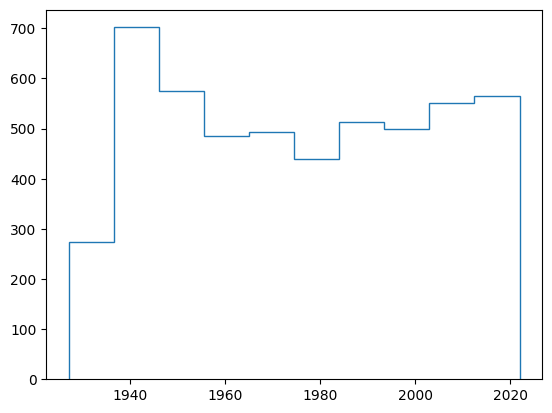

In [62]:
plt.hist(awards_condensed.year, histtype='step') 

### MOVIES3_STATS_CLEAN & AWARDS_CONDENSED MERGE

In [63]:
# Some award names match with column name of movies3_stats_clean, others with column alt_name
# Therefore: 1) get two intermediate merges, 2) Merge them to obtain final merge

movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

display(movies_features_1.sample(5))
display(movies_features_1.shape)
display(movies_features_1.info())

display(movies_features_2.sample(5))
display(movies_features_2.shape)
display(movies_features_2.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
8356,Something Big,1971,Something Big,5.7,924.0,574725,/m/02rl1w,108.0,[English Language],[USA],[Western],135381.0,NaN
4212,K911,1999,K911,5.6,4657.0,2908457,/m/08bvyj,92.0,[English Language],[USA],"[Crime Fiction, Action/Adventure, Action, Come...",1111615.0,NaN
4333,Strange Days,1995,Strange Days,7.1,71881.0,1339563,/m/04tzz5,146.0,[English Language],[USA],"[Crime Fiction, Thriller, Science Fiction, Fut...",9344385.5,NaN
8233,Wishmaster,1997,Wishmaster,5.8,23358.0,456959,/m/02brzs,90.0,[English Language],[USA],"[Horror, Indie, Supernatural, Creature Film, F...",15719109.0,NaN
733,Backstairs at the White House,1979,Backstairs at the White House,8.2,438.0,1641305,/m/05jyb2,540.0,[English Language],[USA],"[Drama, Biopic [feature]]",18724.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1399 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
5753,Copperhead,2008,Copperhead,3.8,645.0,18192574,/m/04cx6nh,90.0,[English Language],[USA],"[Western, Action, Horror]",81800.0,NaN
1862,Dead End,2003,Dead End,6.5,28791.0,1131961,/m/0490lb,84.0,[English Language],"[France, USA]","[Thriller, Horror, Road-Horror, Supernatural, ...",4992159.0,NaN
2176,The Next Karate Kid,1994,The Next Karate Kid,4.5,30573.0,657809,/m/030bds,107.0,[English Language],[USA],"[Drama, Martial Arts Film, Action, Coming of a...",16272897.0,NaN
3828,We're No Angels,1955,We're No Angels,7.4,9517.0,3585054,/m/09n3sq,105.0,"[French Language, English Language]",[USA],"[Christmas movie, Comedy, Religious Film]",3000000.0,NaN
6011,Forget Paris,1995,Forget Paris,6.5,12000.0,8276181,/m/026yq3c,101.0,[English Language],[USA],"[Romantic comedy, Comedy-drama, Drama, Comedy,...",33177694.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [64]:
# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner_x,winner_y
7940,It's Always Fair Weather,1955,It's Always Fair Weather,7.0,3569.0,7693761,/m/0kvfc9,101.0,[English Language],[USA],"[Musical, Musical comedy]",2000000.0,"[False, False]","[False, False]"
3128,Marnie,1964,Marnie,7.1,49227.0,264851,/m/01n7qj,130.0,[English Language],[USA],"[Thriller, Melodrama, Psychological thriller, ...",7000000.0,NaN,NaN
2046,The Replacements,2000,The Replacements,6.6,64662.0,213416,/m/01f86c,114.0,"[English Language, American Sign Language]",[USA],"[Sports, Action/Adventure, Action, Comedy-dram...",55257540.5,NaN,NaN
8336,Hideaway,1995,Hideaway,5.3,6886.0,10193848,/m/02q4sd5,106.0,[English Language],[USA],"[Thriller, Horror, Supernatural, Psychological...",12201255.0,NaN,NaN
6115,The Lonely Lady,1983,The Lonely Lady,3.0,938.0,3235385,/m/0908j2,92.0,[English Language],[USA],"[Romantic drama, Romance Film, Melodrama, Drama]",1223000.0,NaN,NaN


(9496, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner_x     1399 non-null   object 
 13  winner_y     1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(9)
memory usage: 1.0+ MB


None

In [65]:
# Fusing the winner columns
movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')
display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
6759,Captain Horatio Hornblower,1951,Captain Horatio Hornblower R.N.,7.3,6688.0,1022698,/m/03_37m,117.0,[English Language],"[USA, United Kingdom]","[Adventure, Costume drama, Costume Adventure, ...",7143299.5,NaN
1830,The Rage Carrie 2,1999,The Rage Carrie 2,4.7,16679.0,2310825,/m/072w70,105.0,[English Language],[USA],"[Thriller, Horror, Teen]",17762705.0,NaN
5337,George of the Jungle,1997,George of the Jungle,5.5,77186.0,3448890,/m/09c_pm,92.0,"[English Language, Spanish Language]",[USA],"[Parody, Adventure, Jungle Film, Comedy, Famil...",158361428.5,NaN
2613,Titanic,1997,Titanic,7.8,1100000.0,52371,/m/0dr_4,194.0,"[Italian Language, English Language, French La...",[USA],"[Tragedy, Costume drama, Historical fiction, A...",2185372302.0,"[False, False, True, True, True, True, True, F..."
5935,A Lot Like Love,2005,A Lot Like Love,6.6,68000.0,1745339,/m/05spkm,107.0,"[English Language, American Sign Language]",[USA],"[Romantic comedy, Drama, Romance Film, Comedy-...",42886719.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1402 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [66]:
# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

display(movies_features_inc[movies_features_inc['has_won']==True])
display(movies_features_inc[movies_features_inc['nominated']==True])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
6688,The Glass Menagerie,1987,The Glass Menagerie,7.1,1900.0,23663192,/m/06znwqt,134.0,[English Language],[USA],[Drama],895904.0,NaN,False,False,0,0
4910,Punchline,1988,Punchline,5.9,8200.0,4718224,/m/0cjx6q,122.0,[English Language],[USA],"[Drama, Comedy-drama, Comedy, Stand-up comedy]",21042667.0,NaN,False,False,0,0
4848,Kuffs,1992,Kuffs,5.9,10883.0,2674286,/m/07x211,102.0,[English Language],[USA],"[Crime Fiction, Action/Adventure, Action, Acti...",21142815.0,NaN,False,False,0,0
7263,Deliverance,1972,Deliverance,7.7,107785.0,101899,/m/0pttd,110.0,[English Language],[USA],"[LGBT, Thriller, Adventure, Action/Adventure, ...",41028352.5,"[False, False, False]",False,True,0,3
4012,Casanova,2005,Casanova,8.5,97.0,3201442,/m/08yy2g,111.0,[English Language],[USA],"[Romantic comedy, Adventure, Costume drama, Pe...",37691644.0,NaN,False,False,0,0


(9496, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  revenue         9496 non-null   object 
 12  winner          1402 non-null   object 
 13  has_won         9496 non-null   bool   
 14  nominated       9496 non-null   bool   
 15  nbr_won         9496 non-null   int64  
 16  nbr_nomination  9496 non-null   int64  
dtypes: Int64(1), bool(2), float64(3),

None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
1,Alexander's Ragtime Band,1938,Alexander's Ragtime Band,6.89,2135.0,10408933,/m/02qc0j7,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",3350335.0,"[False, False, True, False, False, False]",True,True,1,6
21,Midnight Express,1978,Midnight Express,7.50,79459.0,103021,/m/0p_sc,121.0,"[French Language, English Language]","[USA, United Kingdom]","[Thriller, LGBT, Indie, Crime Fiction, Escape ...",35000000.0,"[False, False, False, True, False, True]",True,True,2,6
25,Superman,1978,Superman,7.40,173964.0,362719,/m/01_mdl,151.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Adventure, Superhero movie, ...",296890259.0,"[False, False, False, True]",True,True,1,4
29,Sweeney Todd The Demon Barber of Fleet Street,2007,Sweeney Todd The Demon Barber of Fleet Street,7.30,366420.0,5549065,/m/0ds11z,117.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Tragedy, Horror, Supernatural,...",145489732.0,"[False, True, False]",True,True,1,3
47,Shaft,1971,Shaft,6.60,18971.0,76345,/m/0k47y,98.0,"[English Language, American English]",[USA],"[Crime Fiction, Thriller, Detective, Action/Ad...",14405849.0,"[False, True]",True,True,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.00,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5,"[True, True, True, True, True, True, True, Tru...",True,True,11,11
9431,Syriana,2005,Syriana,6.90,130444.0,2392280,/m/078sj4,126.0,"[Arabic Language, English Language, French Lan...",[USA],"[Thriller, Drama, Docudrama, Political thriller]",95918660.0,"[True, False]",True,True,1,2
9436,Phantom of the Opera,1943,Phantom of the Opera,6.40,7281.0,1271371,/m/04n_0x,93.0,[English Language],[USA],"[Drama, Musical, Horror, Romance Film]",3488000.0,"[True, True, False, False]",True,True,2,4
9465,The Battle of Midway,1942,The Battle of Midway,6.10,2083.0,7593569,/m/02665zq,50.0,[English Language],[USA],"[History, Black-and-white, Short Film, Propaga...",65719.0,[True],True,True,1,1


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
1,Alexander's Ragtime Band,1938,Alexander's Ragtime Band,6.89,2135.0,10408933,/m/02qc0j7,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",3350335.0,"[False, False, True, False, False, False]",True,True,1,6
15,Straw Dogs,1971,Straw Dogs,7.40,59968.0,196176,/m/01bwgr,118.0,[English Language],"[USA, United Kingdom]","[Thriller, Drama]",28079553.0,[False],False,True,0,1
21,Midnight Express,1978,Midnight Express,7.50,79459.0,103021,/m/0p_sc,121.0,"[French Language, English Language]","[USA, United Kingdom]","[Thriller, LGBT, Indie, Crime Fiction, Escape ...",35000000.0,"[False, False, False, True, False, True]",True,True,2,6
25,Superman,1978,Superman,7.40,173964.0,362719,/m/01_mdl,151.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Adventure, Superhero movie, ...",296890259.0,"[False, False, False, True]",True,True,1,4
29,Sweeney Todd The Demon Barber of Fleet Street,2007,Sweeney Todd The Demon Barber of Fleet Street,7.30,366420.0,5549065,/m/0ds11z,117.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Tragedy, Horror, Supernatural,...",145489732.0,"[False, True, False]",True,True,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9482,April Love,1957,April Love,6.20,713.0,26254041,/m/0b76vn7,99.0,[English Language],[USA],"[Animal Picture, Musical, Drama, Film adaptati...",5245675.0,[False],False,True,0,1
9485,The Great White Hope,1970,The Great White Hope,6.90,2560.0,18046658,/m/04gghr1,103.0,"[Spanish Language, German Language, English La...",[USA],"[Sports, Romance Film, Biography, Drama, Boxing]",2695525.0,"[False, False]",False,True,0,2
9490,Twister,1996,Twister,6.40,194938.0,303933,/m/01s7w3,113.0,[English Language],[USA],"[Action/Adventure, Disaster]",495970562.0,"[False, False]",False,True,0,2
9492,Coming to America,1988,Coming to America,7.10,196000.0,54540,/m/0f7hw,117.0,[English Language],[USA],"[Romantic comedy, Comedy of manners, Drama, Co...",288752301.0,"[False, False]",False,True,0,2


### a) Box-office revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [67]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
10,1810,0.98,0.00
146,1946,1.55,0.08
125,1925,1.39,0.02
160,1960,2.35,0.02
92,1892,0.72,0.00


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
7993,Traveller,1997,Traveller,6.1,2108.0,5646183,/m/0dy16d,101.0,[English Language],[USA],"[Crime Fiction, Romance Film, Drama, Indie]",500649.0,NaN,False,False,0,0,39297.409733
474,The Searchers,1956,The Searchers,7.9,88443.0,76335,/m/0k45b,119.0,"[Spanish Language, English Language, Navajo La...",[USA],"[Action/Adventure, Revisionist Western, Wester...",55020275.5,NaN,False,False,0,0,25472349.768519
1100,I Want to Live!,1958,I Want to Live!,7.5,6628.0,193854,/m/01bj93,120.0,[English Language],[USA],"[Crime Fiction, Crime Drama, Black-and-white, ...",5641711.0,"[True, False, False, False, False, False]",True,True,1,6,2463629.257642
3713,Eve of Destruction,1991,Eve of Destruction,4.9,2285.0,14513043,/m/03d5ypd,98.0,[English Language],[USA],"[Thriller, Action/Adventure, Science Fiction, ...",5451119.0,NaN,False,False,0,0,504266.327475
4088,Nuts,1987,Nuts,6.6,6642.0,4362550,/m/0bz7ms,116.0,[English Language],[USA],"[Crime Fiction, Musical, Drama, Courtroom Drama]",30950002.0,NaN,False,False,0,0,3431264.079823


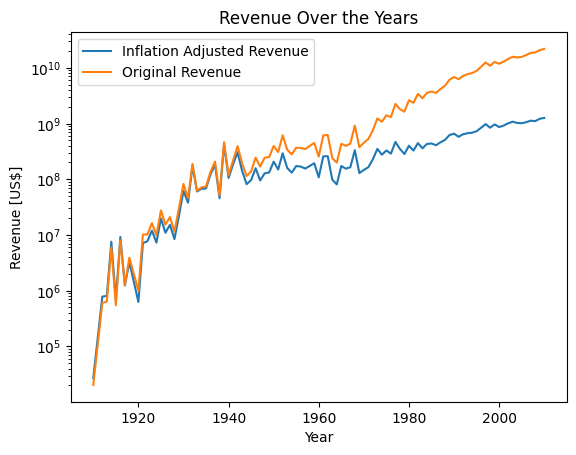

In [68]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

# 'movies2_clean' ot whatever dataset is the right one...

In [69]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
293,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,NaN,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1308,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1865,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,NaN,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2505,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5502,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6135,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
9055,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [70]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
9176,The French Connection,1971,The French Connection,7.7,121836.0,99463,/m/0pd64,104.0,"[French Language, English Language]",[USA],"[Thriller, Crime Fiction, Detective fiction, C...",45037245.0,"[True, False, False, True, True, True, False, ...",True,True,5,8,14030294.392523,0.085261
4953,A Very Brady Sequel,1996,A Very Brady Sequel,5.8,10000.0,3142340,/m/08v3bw,89.0,[English Language],[USA],"[Parody, Comedy]",21440752.0,NaN,False,False,0,0,1722148.75502,0.002056
9463,Kiss of Death,1947,Kiss of Death,7.4,8343.0,616805,/m/02x0cf,98.0,[English Language],[USA],"[Thriller, Crime Fiction, Psychological thrill...",1373196.0,"[False, False]",False,True,0,2,775816.949153,0.008152
5132,The Mack,1973,The Mack,6.5,2993.0,1308068,/m/04rqk7,110.0,[English Language],[USA],"[Crime Fiction, Thriller, Action/Adventure, Bl...",10200000.0,NaN,False,False,0,0,2897727.272727,0.00827
4230,The Barefoot Contessa,1954,The Barefoot Contessa,6.9,11239.0,1364174,/m/04wxqx,128.0,"[Italian Language, English Language, Spanish L...","[USA, Italy]","[Crime Fiction, Melodrama, Mystery, Drama, Rom...",1722573.75,"[True, False]",True,True,1,2,808720.070423,0.00616


(9496, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  revenue         9496 non-null   object 
 12  winner          1402 non-null   object 
 13  has_won         9496 non-null   bool   
 14  nominated       9496 non-null   bool   
 15  nbr_won         9496 non-null   int64  
 16  nbr_nomination  9496 non-null   int64  
 17  revenue_infl    9496 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.492
Method:                 Least Squares   F-statistic:                              96.91
Date:                Mon, 18 Dec 2023   Prob (F-statistic):                    2.63e-16
Time:                        17:35:33   Log-Likelihood:                         -2084.8
No. Observations:                  99   AIC:                                      4172.
Df Residuals:                      98   BIC:                                      4174.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
5853,Fathers' Day,1997,Fathers' Day,5.3,15000.0,961937,/m/03tpl2,99.0,[English Language],[USA],"[Buddy film, Road movie, Screwball comedy, Adv...",35681080.0,NaN,False,False,0,0,2800712.715856,0.002864,2757943.760083
8936,Men with Guns,1997,Men with Guns,7.6,2760.0,9105282,/m/027xt9k,128.0,"[Tzotzil language, Maya, Yucatán Language, Spa...",[USA],"[Action/Adventure, Drama, Political drama, Adv...",956801.5,NaN,False,False,0,0,75102.158556,0.000077,73955.293017
2602,Edge of Darkness,2010,Edge of Darkness,6.6,94791.0,18949667,/m/04jn6y7,117.0,[English Language],"[USA, United Kingdom]","[Thriller, Mystery, Crime Fiction, Drama]",80502999.5,NaN,False,False,0,0,4650664.326979,0.003692,4587301.248502
922,Love at Large,1990,Love at Large,5.7,1303.0,19011948,/m/04jb638,97.0,[English Language],[USA],"[Thriller, Romantic comedy, Mystery, Comedy, C...",1436308.0,NaN,False,False,0,0,138506.075217,0.00021,135615.783158
9141,Bee Movie,2007,Bee Movie,6.1,160668.0,2863319,/m/087m22,88.0,[English Language],[USA],"[Adventure, Children's/Family, Computer Animat...",283750238.5,NaN,False,False,0,0,17238775.121507,0.015323,16983663.259988


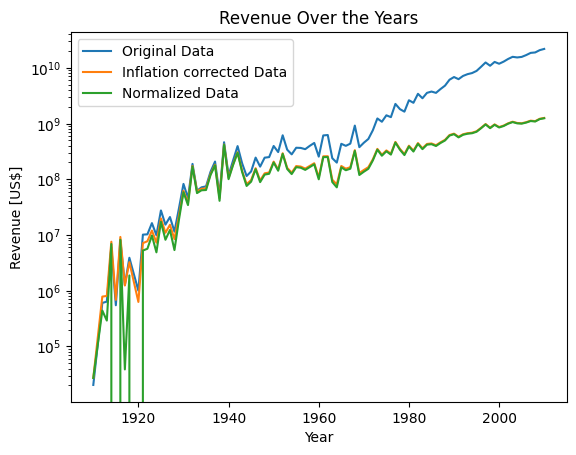

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
6992,Uncle Buck,1989,Uncle Buck,7.0,88000.0,657764,/m/030b8c,100.0,[English Language],[USA],"[Family Film, Drama, Comedy, Domestic Comedy]",False,False,0,0,0.012973,7878829.907527
643,Cornered,1945,Cornered,6.6,2330.0,2060664,/m/06j9zh,102.0,[English Language],[USA],"[Thriller, Mystery, Black-and-white, Film noir...",False,False,0,0,0.016401,1483990.53449
74,Open Season 3,2010,Open Season 3,5.0,11622.0,28010827,/m/0c3tkft,75.0,[English Language],[USA],"[Computer Animation, Family Film, Animation]",False,False,0,0,0.001214,1508751.554637
5606,Eight Legged Freaks,2002,Eight Legged Freaks,5.5,57125.0,956388,/m/03t6l4,95.0,[English Language],"[USA, Australia]","[Natural horror films, Science Fiction, Horror...",False,False,0,0,0.002405,2387733.465913
8398,I'm No Angel,1933,I'm No Angel,6.9,3544.0,3471403,/m/09f825,88.0,[English Language],[USA],"[Romantic comedy, Romance Film, Musical, Black...",False,False,0,0,0.059343,3348986.376785


(9496, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  has_won         9496 non-null   bool   
 12  nominated       9496 non-null   bool   
 13  nbr_won         9496 non-null   int64  
 14  nbr_nomination  9496 non-null   int64  
 15  revenue_part    9496 non-null   object 
 16  revenue_norm    9496 non-null   object 
dtypes: Int64(1), bool(2), float64(3),

None

In [71]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

display(movies_features.sample(5))
display(movies_features.shape)
display(movies_features.info())


In [72]:
display(movies_features[movies_features['name']=='Star Wars Episode IV A New Hope'])
display(movies_features[movies_features['name']=='The Godfather'])
display(movies_features[movies_features['name']=='The Matrix'])
display(movies_features[movies_features['name']=='Scream'])
display(movies_features[movies_features['name']=='Rambo'])
display(movies_features[movies_features['name']=='Rocky'])
display(movies_features[movies_features['name']=='Forrest Gump'])
display(movies_features[movies_features['name'].str.contains('The Lord of the Ring')])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9387,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153857547.453283


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
4294,The Godfather,1972,The Godfather,9.2,1804773.0,2466773,/m/07g1sm,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",True,True,3,11,0.346482,75424417.962097


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
6718,The Matrix,1999,The Matrix,8.7,1877771.0,30007,/m/07cz2,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",True,True,4,4,0.035012,33224833.843101


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7188,Scream,1996,Scream,7.4,335040.0,113549,/m/0sy44,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",False,False,0,0,0.017242,14187730.463848


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9024,Rambo,2008,Rambo,7.0,230814.0,18850952,/m/03clwtw,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",False,False,0,0,0.005798,6299708.167102


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9283,Rocky,1976,Rocky,8.1,563359.0,45772,/m/0cf08,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",True,True,3,10,0.14734,40746767.058961


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7515,Forrest Gump,1994,Forrest Gump,8.8,1900000.0,41528,/m/0bdjd,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",True,True,6,13,0.084227,56386646.746294


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
989,The Lord of the Rings The Two Towers,2002,The Lord of the Rings The Two Towers,8.8,1622144.0,173944,/m/017gm7,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",True,True,2,6,0.06191,61467876.14508
8551,The Lord of the Rings,1978,The Lord of the Rings,6.2,33307.0,396607,/m/023cjg,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",False,False,0,0,0.014257,4832129.22638
9292,The Lord of the Rings The Fellowship of the Ring,2001,The Lord of the Rings The Fellowship of the Ring,8.8,1817662.0,173941,/m/017gl1,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",True,True,4,13,0.06487,58501942.646399
9402,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.0,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",True,True,11,11,0.067723,71909451.897554


### b) Reviews

### c) Awards

### d) Plot similarity

In [73]:
movies.reset_index()

,index,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,..."
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[USA],"[Mystery, Biographical film, Drama, Crime Drama]"
2,5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Indie, Black-and-whi..."
3,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]"
4,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,[English Language],[USA],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...,...
28816,74810,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com..."
28817,74811,34474142,/m/0cpy07r,Frontier Fury,1943,NaN,55.0,[English Language],[USA],[Western]
28818,74815,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[Italian Language, English Language]","[France, USA]","[Parody, Americana, Comedy]"
28819,74817,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,[English Language],[USA],"[Comedy film, Romance Film, Musical]"


In [74]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
corresp_table=merged_df.drop(columns=[ 'plot', 'id_freebase', 'name', 'year', 'revenue', 'runtime',
       'lang', 'countries', 'genres'])
corresp_table.head()


,id_wiki
0,2231378
1,595909
2,5272176
3,1952976
4,24225279


C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', '

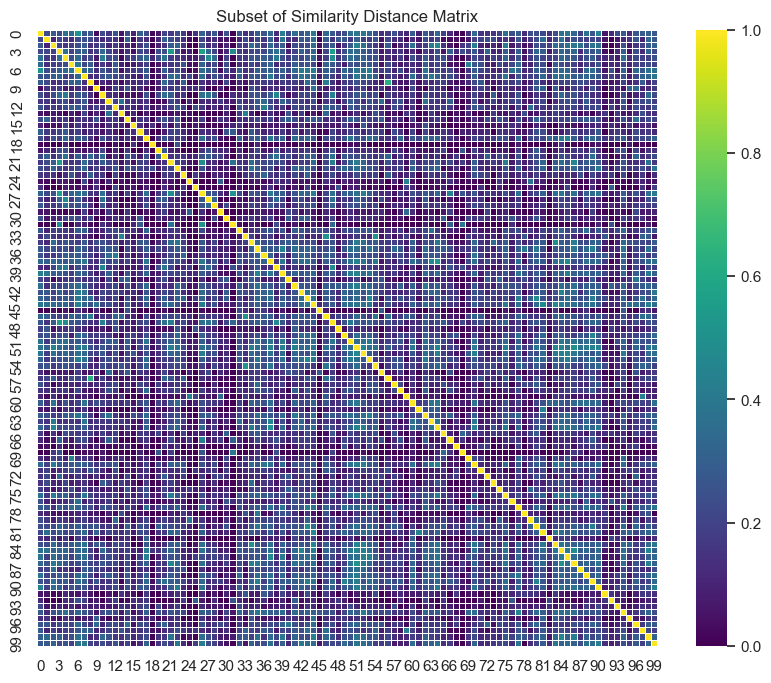

In [75]:
similarity_matrix = plot_similarity_heatmap(merged_df, 'plot')

In [76]:

# Example to find most similar movie
given_movie_index = 1665  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']
most_similar_movie_names = merged_df.iloc[max_indices[9]]['name']

print("Given Movie Name:", given_movie_name)
print("Most Similar Movie Names:", most_similar_movie_names)
print(max_indices)

Given Movie Name: Blood of Dracula's Castle
Most Similar Movie Names: Kid Auto Races at Venice
[10055 14360   268 14623  3737 10079 14981  1665 10742  7923]


In [77]:
NAME_OF_THE_MOVIE= 'Star wars'
display( movies_features[movies_features['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
544,Star Wars The Clone Wars,2008,Star Wars The Clone Wars,5.9,65696.0,15726696,/m/0cpllql,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute...",False,False,0,0,0.003664,3981186.524569
688,Star Wars Episode II Attack of the Clones,2002,Star Wars Episode II Attack of the Clones,6.6,699970.0,50957,/m/0dfw0,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,True,0,1,0.045064,44741897.624018
1849,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,8.3,1029353.0,50744,/m/0ddjy,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.157184,54541848.003469
5791,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,6.5,793302.0,50793,/m/0ddt_,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ...",False,True,0,3,0.077363,73413587.642758
6464,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,8.7,1260121.0,53964,/m/0f3m1,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.178028,69033992.432369
6491,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,2.1,15255.0,185264,/m/0199wf,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani...",False,False,0,0,0.04091,13865149.813119
7172,Star Wars Episode III Revenge of the Sith,2005,Star Wars Episode III Revenge of the Sith,7.6,777101.0,55447,/m/0fdv3,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad...",False,True,0,1,0.053603,53322205.431633
7849,Star Wars Revelations,2005,Star Wars Revelations,5.0,1180.0,1823554,/m/05zsyv,47.0,[English Language],[USA],"[Fan film, Indie]",False,False,0,0,0.00008,79344.592052
9387,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153857547.453283


In [78]:
scifi_before_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] < 1977)].index
scifi_after_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] > 1977)].index
comedy_df=merged_df[merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)].index

star_wars_movies = merged_df[merged_df['name'].str.contains('Star Wars', case=False, na=False)]

a=calculate_mean_similarity_1(similarity_matrix, 3769	, scifi_before_star_wars)
b=calculate_mean_similarity_1(similarity_matrix, 3769, scifi_after_star_wars)
print('Similarity means before Star Wars:{}'.format(a))
print('Similarity means after Star Wars:{}'.format(b))


Similarity means before Star Wars:0.17622116642391022
Similarity means after Star Wars:0.21030837821739862


In [79]:
import numpy as np
import pandas as pd

def find_most_influential_movie(similarity_matrix, genre, df):
    """
    Find the movie within a specific genre that has the most similarities with other movies in that genre.

    Parameters:
    - similarity_matrix (numpy.ndarray): Matrix containing pairwise similarities between movie plots.
    - genre (str): The genre for which to find the most influential movie.
    - df (pandas.DataFrame): DataFrame containing movie information, including genres.

    Returns:
    - str: The name of the most influential movie in the specified genre.
    """
    # Filter movies of the specified genre
    genre_movies = df[df['genres'].apply(lambda genres: genre in genres)]

    # Get the indices of movies of the specified genre
    genre_indices = genre_movies.index.tolist()

    # Initialize variables to store the most influential movie
    max_avg_similarity = 0.0
    most_influential_movie = None

    # Iterate through movies and compute average similarity to other movies in the genre
    for i in range(len(genre_indices)):
        avg_similarity_to_genre = np.mean(similarity_matrix[genre_indices[i], genre_indices])
        
        # Update most influential movie
        if avg_similarity_to_genre > max_avg_similarity:
            max_avg_similarity = avg_similarity_to_genre
            most_influential_movie = df.loc[genre_indices[i], 'name']

    return most_influential_movie

# Example usage:
# Assuming similarity_matrix is your pre-computed similarity matrix, and df is your DataFrame
# Replace 'Science Fiction' with the genre you are interested in
most_influential_movie = find_most_influential_movie(similarity_matrix, 'Crime Fiction', merged_df)

print(f"The most influential movie in Science Fiction is: {most_influential_movie}")


The most influential movie in Science Fiction is: I, the Jury


In [80]:
# Example usage:
# Assuming 'merged_df' is your DataFrame, 'similarity_matrix' is your pre-computed similarity matrix
movie_index = 4906  # Replace with the actual index of the film in the DataFrame
film_row = merged_df.iloc[movie_index]
genre=film_row['genres'][0]
mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)

print(f"Mean Similarity 10 Years Before: {mean_similarity_before:.2f}")
print(f"Mean Similarity 10 Years After: {mean_similarity_after:.2f}")


Mean Similarity 10 Years Before: 0.18
Mean Similarity 10 Years After: 0.19


## 3) Method for identifying pivotal movies

### 3.1) TEST

In [81]:
# Help to find the name of a wiki index
id_wiki=62440
print(merged_df[merged_df['id_wiki']==id_wiki]['name'])

5289    The Sting
Name: name, dtype: object


In [82]:
# Help to show candidates movie for a given trend
trend_id=3 # variable to change
pa=pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
#Star Wars =320
#Lord of the ring = 176
print('genre {}, years {}'.format(candidates[trend_id][0], candidates[trend_id][1]))
from helpers import *
pa=candidates[trend_id][2].copy()
columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase',
       'runtime', 'lang', 'countries', 'has_won', 'nominated',
        'revenue_part']
pa=pa.drop(columns=columns_to_drop).copy()
pb=pa.merge(movies_features, on='id_wiki')
pb['trend_number'] = trend_id*np.ones((len(pb), 1))


pb= calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
pb.drop(columns=columns_to_drop_2, inplace=True)
display(pb)

genre Action Thrillers, years 1975


,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,delta_similarity
0,314406,Bring Me the Head of Alfredo Garcia,1974,Bring Me the Head of Alfredo Garcia,7.4,19851.0,"[Thriller, Action/Adventure, Adventure, Road m...",0,0,142071.860199,3.0,1.601040
1,4210681,Hell Up in Harlem,1973,Hell Up in Harlem,5.9,1538.0,"[Thriller, Crime Fiction, Gangster Film, Indie...",0,0,399998.658859,3.0,NaN
2,4040311,Truck Turner,1974,Truck Turner,6.9,3081.0,"[Thriller, Crime Fiction, Action Thrillers, Ac...",0,0,43552.962667,3.0,1.163959
3,19269176,The Outside Man,1972,The Outside Man,6.5,948.0,"[Crime Fiction, Thriller, Action Thrillers, Ga...",0,0,1249016.260246,3.0,-6.988216
4,1237909,Sweet Sweetback's Baadasssss Song,1971,Sweet Sweetback's Baadasssss Song,5.5,5315.0,"[Crime Fiction, Thriller, Indie, Action/Advent...",0,0,5211140.1661,3.0,-0.123937
5,14418816,Madame Sin,1972,Madame Sin,5.8,1053.0,"[Thriller, Action Thrillers, Action, Drama, Spy]",0,0,16070.712677,3.0,-3.427988
6,433285,Bullitt,1968,Bullitt,7.4,68371.0,"[Crime Fiction, Thriller, Chase Movie, Action ...",1,2,14867875.705547,3.0,-0.033880
7,7010510,The Super Cops,1974,The Super Cops,6.6,1042.0,"[Crime Fiction, Thriller, Docudrama, Action Th...",0,0,299788.430178,3.0,0.080218
8,301798,Dirty Harry,1971,Dirty Harry,7.7,155411.0,"[Thriller, Action Thrillers, Action/Adventure,...",0,0,12331122.269486,3.0,-1.022978
9,1126356,Mr. Majestyk,1974,Mr. Majestyk,6.7,8736.0,"[Thriller, Action Thrillers, Gangster Film, Ac...",0,0,31871.854375,3.0,3.602022


### 3.2) Serious Buisness Machine learning

In [83]:
# CREATION OF DF_CANDIDATES

columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase', 'runtime', 'lang',
    'countries',]
from helpers import *
result_df = pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
for trend_id in range(len(candidates)):
    if len(candidates[trend_id][2])>3 : # get candidates subset with at least 3 candidates
        pc = candidates[trend_id][2].copy()

        pc.drop(columns=columns_to_drop, inplace=True)
        pb = pc.merge(movies_features, on='id_wiki')
        pb['trend_number'] = trend_id * np.ones((len(pb), 1))
        pb = calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
        pb.drop(columns=columns_to_drop_2, inplace=True)

        # Concatenate the current DataFrame with the result_df
        result_df = pd.concat([result_df, pb], ignore_index=True)
    else :
        continue

# Display the merged DataFrame
result_df.info

C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

<bound method DataFrame.info of        id_wiki                      name  year                  alt_name  \
0      5286922                 The Phynx  1970                 The Phynx   
1       298925    Take the Money and Run  1969    Take the Money and Run   
2      3059075              Brain Donors  1992              Brain Donors   
3      1716921  Amazon Women on the Moon  1987  Amazon Women on the Moon   
4        75222                Spaceballs  1987                Spaceballs   
...        ...                       ...   ...                       ...   
7954   3759313           Day of the Dead  2008           Day of the Dead   
7955  16794053                Quarantine  2008                Quarantine   
7956   2271177  Resident Evil Extinction  2007  Resident Evil Extinction   
7957   8586622             Planet Terror  2007             Planet Terror   
7958    915499          Land of the Dead  2005          Land of the Dead   

      rating     votes                                 

In [84]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 10 candidates
r=result_df.copy()
# Filter candidates that have no delta_similarity
r.dropna(subset=['delta_similarity'], inplace=True)
unique_names_count = len(r['name'].unique()) # number of different movies
print ('There is {} different movies'.format(unique_names_count))
movie_counts_per_trend = r['trend_number'].value_counts()
# Filter trends with less than 10 movies
trends_with_few_movie = movie_counts_per_trend[movie_counts_per_trend < 10].index

# Remove rows where 'trend_number' is in trends_with_one_movie
result_df_filtered = r[~r['trend_number'].isin(trends_with_few_movie)]




There is 3634 different movies


In [85]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = result_df_filtered.copy()
result_df_standardized = result_df_filtered.copy()
# Define the features to standardize
features_to_standardize = ['rating','nbr_won','nbr_nomination','revenue_norm','delta_similarity']

# Group by 'trend_number' and standardize the features within each group
scaler = StandardScaler()

def standardize_group(group):
    group[features_to_standardize] = scaler.fit_transform(group[features_to_standardize])
    return group

result_df_standardized = re.groupby('trend_number').apply(standardize_group)
result_df_ungrouped = result_df_standardized.drop('trend_number', axis=1).reset_index().copy()
# Display the result
display(result_df_standardized)
unique_names_count = len(result_df_filtered['name'].unique())


id_wiki                          name  year  \
trend_number                                                      
2.0          11       76345                         Shaft  1971   
             12     9068424  The Legend of Nigger Charley  1972   
             13     3730244     The Ballad of Cable Hogue  1970   
             14    12807520              The Stone Killer  1973   
             16        4727                        Batman  1966   
...                     ...                           ...   ...   
386.0        7954   3759313               Day of the Dead  2008   
             7955  16794053                    Quarantine  2008   
             7956   2271177      Resident Evil Extinction  2007   
             7957   8586622                 Planet Terror  2007   
             7958    915499              Land of the Dead  2005   

                                       alt_name    rating     votes  \
trend_number                                                          
2.0          11                           Shaft  0.109709   18971.0   
             12    The Legend of Nigger Charley -0.641797     457.0   
             13       The Ballad of Cable Hogue  0.861215    9626.0   
             14                The Stone Killer -0.516546    3227.0   
             16                          Batman -0.015542   32993.0   
...                                         ...       ...       ...   
386.0        7954               Day of the Dead -0.631372   21030.0   
             7955                    Quarantine  0.286694   73694.0   
             7956      Resident Evil Extinction  0.470308  195449.0   
             7957                 Planet Terror  1.021147  209447.0   
             7958              Land of the Dead  0.470308   96728.0   

                                                              genres  has_won  \
trend_number                                                                    
2.0          11    [Crime Fiction, Thriller, Detective, Action/Ad...     True   
             12    [Western, Action, Drama, Blaxploitation, Hybri...    False   
             13    [Indie, Action/Adventure, Revisionist Western,...    False   
             14                              [Crime Fiction, Action]    False   
             16    [Parody, Superhero movie, Camp, Action/Adventu...    False   
...                                                              ...      ...   
386.0        7954  [Thriller, Horror, Doomsday film, Cult, Splatt...    False   
             7955  [Thriller, Science Fiction, Horror, Zombie Fil...    False   
             7956  [Thriller, Science Fiction, Horror, Sci-Fi Hor...    False   
             7957  [Thriller, Action/Adventure, Science Fiction, ...    False   
             7958  [Thriller, Science Fiction, Horror, Indie, Doo...    False   

                   nominated   nbr_won  nbr_nomination revenue_part  \
trend_number                                                          
2.0          11         True  0.737756        0.552272     0.027272   
             12        False -0.234096       -0.353851     0.002567   
             13        False -0.234096       -0.353851     0.009405   
             14        False -0.234096       -0.353851     0.001124   
             16        False -0.234096       -0.353851     0.001032   
...                      ...       ...             ...          ...   
386.0        7954      False  0.000000        0.000000     0.000018   
             7955      False  0.000000        0.000000     0.002396   
             7956      False  0.000000        0.000000      0.00762   
             7957      False  0.000000        0.000000     0.000483   
             7958      False  0.000000        0.000000     0.002947   

                   revenue_norm  trend_number  delta_similarity  
trend_number                                                     
2.0          11       -0.024360           2.0          1.163734  
             12       -0.492038           2.0   

In [86]:
# LIST OF TRAINING

#pivotal : The Lord of the Rings The Fellowship of the Ring :173941
        # Star Wars Episode IV A New Hope : 52549
         # Forrest Gump	: 41528
         # Rocky : 45772
         # Pulp Fiction : 54173
         # Scary Movie : 277667
         # Citizen Kane : 5224
         # The Truman Show : 232711
         # 2001 A Space Odyssey : 23941708
         # The Godfather: 2466773
         # Vertigo: 76617
         #103021 Midnight Express
#non-pivotal : # Superman 362719
                # Harry Poter 667368
                # Star Wars Episode V The Empire Strikes Back : 53964
                # Escape from Alcatraz	: 1707516
                # A League of Their Own :543433
                #The Monster That Challenged the World	: 9595500
                # Basket Case: 2283532
                # 99015	Doctor Dolittle
                # 22557327 The MiniSkirt Mob	
        



In [87]:
# TRAINING PART

# PIVOTAL MOVIES
ROCKY = result_df_standardized[result_df_standardized['id_wiki'] == 45772].head(1)
STAR_WARS_IV = result_df_standardized[result_df_standardized['id_wiki'] == 52549].head(1)
SPACE_ODYSSEY = result_df_standardized[result_df_standardized['id_wiki'] == 23941708].head(1)
THE_GODFATHER = result_df_standardized[result_df_standardized['id_wiki'] == 2466773].head(1)
MIDNIGHT_EXPRESS = result_df_standardized[result_df_standardized['id_wiki'] == 103021].head(1)
LORD_OF_THE_RING_I = result_df_standardized[result_df_standardized['id_wiki'] == 173941].head(1)

# NON-PIVOTAL MOVIES
SUPERMAN = result_df_standardized[result_df_standardized['id_wiki'] == 362719].head(1)
HARRY_POTTER = result_df_standardized[result_df_standardized['id_wiki'] == 667368].head(1)
STAR_WARS_V = result_df_standardized[result_df_standardized['id_wiki'] == 53964].head(1)

# Concatenate all DataFrames
all_movies = pd.concat([ROCKY, STAR_WARS_IV, SPACE_ODYSSEY, THE_GODFATHER, MIDNIGHT_EXPRESS, LORD_OF_THE_RING_I, SUPERMAN, HARRY_POTTER, STAR_WARS_V])
features_train = all_movies[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
y_train = [1] * 6 + [0] * 3
# Display the concatenated DataFrame
display(features_train)

# Display y_train
print(y_train)



,,rating,nbr_won,nbr_nomination,revenue_norm,delta_similarity
trend_number,,,,,,
339.0,6352,2.116729,4.898979,4.747717,4.726369,-0.200504
100.0,1792,2.783015,5.754758,5.313877,6.682802,0.764863
266.0,4919,1.607597,0.789689,2.080955,5.695234,-0.022841
123.0,2295,3.047065,2.649696,4.810197,7.437823,0.208830
50.0,744,0.765120,1.592006,1.011300,2.412414,-0.368055
176.0,3804,1.918235,4.543441,4.615565,2.645212,2.198514
320.0,5947,1.049544,1.481845,2.409559,2.343636,0.821649
176.0,3795,0.998066,-0.267261,-0.264144,2.549064,0.643770
174.0,3726,2.510308,-0.171499,-0.310087,4.786157,1.837826


[1, 1, 1, 1, 1, 1, 0, 0, 0]


In [88]:
# INFO FROM TRAINING

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(features_train,y_train)
# Print coefficients
print("Coefficients:", logistic.coef_)

# Print intercept
print("Intercept:", logistic.intercept_)

Coefficients: [[-0.06959137  0.7234181   0.34616507  0.46383485 -0.64603623]]
Intercept: [-2.44447178]


In [89]:
# PREDICTION FOR EVERY TRENDS

from sklearn.linear_model import LogisticRegression

# Assuming features_train and y_train are defined
# ...

grouped_by_trend = result_df_ungrouped.groupby('trend_number')
# Dictionary to store most likely pivotal movie for each group
most_likely_pivotal = {}

# Iterate over groups
for trend_number, group_df in grouped_by_trend:
    # Select features and labels for the group
    features_group = group_df[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
    
    # Predict probabilities for being pivotal
    probabilities = logistic.predict_proba(features_group)[:, 1]
    
    # Identify the index with the highest probability
    most_likely_index = probabilities.argmax()
    
    # Get the details of the most likely pivotal movie
    most_likely_movie = group_df.iloc[most_likely_index]
    
    # Store the result in the dictionary
    most_likely_pivotal[trend_number] = most_likely_movie

# Display the most likely pivotal movie for each group
for trend_number, movie_info in most_likely_pivotal.items():
    print(f"Trend {candidates[int(trend_number)][0]} of year {candidates[int(trend_number)][1]}: Most Likely Pivotal Movie - {movie_info['name']}")



Trend Action of year 1974: Most Likely Pivotal Movie - The Sting
Trend Action Thrillers of year 1975: Most Likely Pivotal Movie - The French Connection
Trend Action Thrillers of year 1995: Most Likely Pivotal Movie - The Hunt for Red October
Trend Action/Adventure of year 1973: Most Likely Pivotal Movie - Patton
Trend Adventure of year 1939: Most Likely Pivotal Movie - Anthony Adverse
Trend Alien Film of year 1992: Most Likely Pivotal Movie - Predator
Trend Animal Picture of year 1998: Most Likely Pivotal Movie - Beethoven's 2nd
Trend Animated Musical of year 2000: Most Likely Pivotal Movie - The Lion King
Trend Animation of year 2006: Most Likely Pivotal Movie - The Incredibles
Trend B-movie of year 1963: Most Likely Pivotal Movie - Creature from the Haunted Sea
Trend Biographical film of year 1956: Most Likely Pivotal Movie - Viva Zapata!
Trend Biographical film of year 1981: Most Likely Pivotal Movie - Midnight Express
Trend Biography of year 1977: Most Likely Pivotal Movie - Patton

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?